### Data Cleaning

We had to clean some data manually.

For both excel files from statista, we had to move the columns and remove the title. So it went from this:  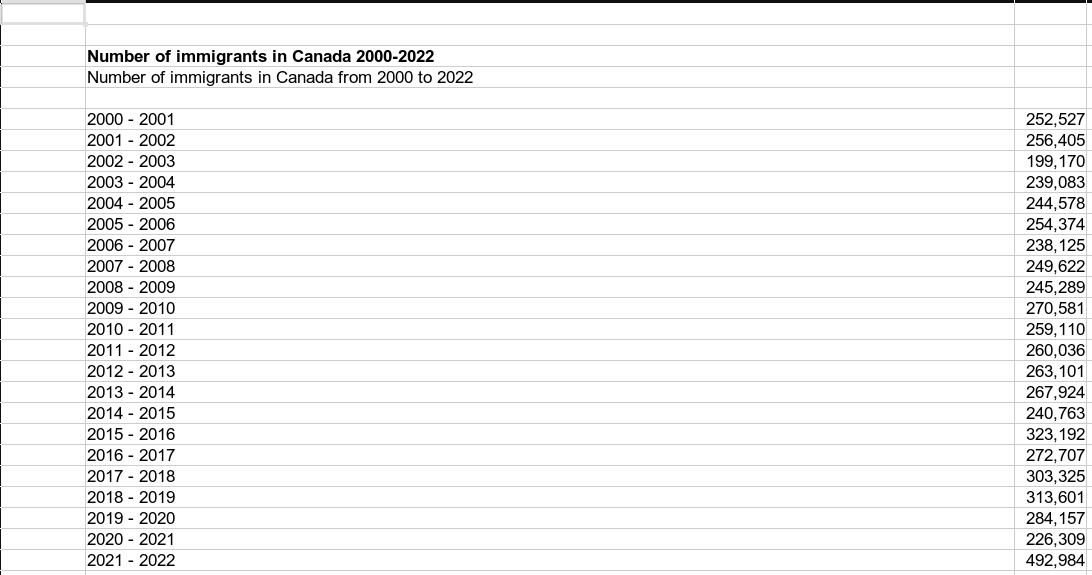

To this : 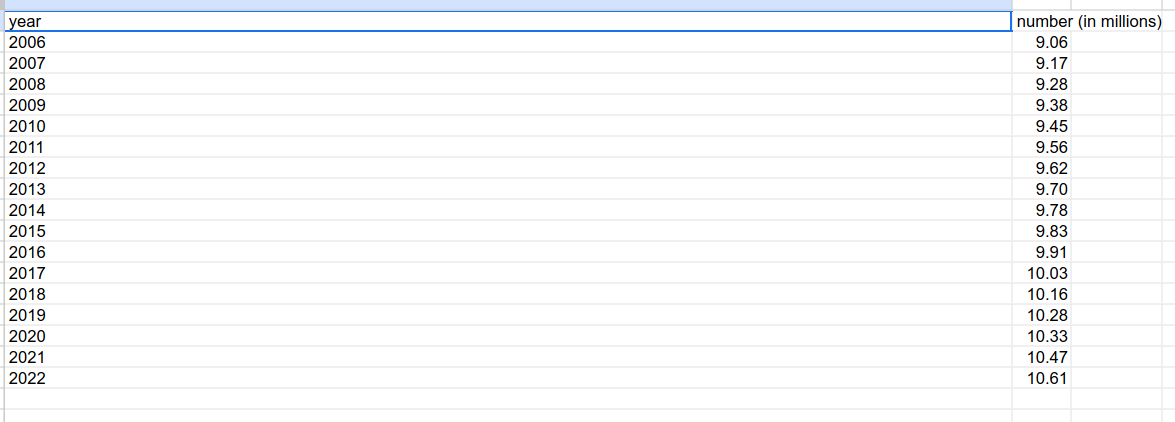

That way both the excel files could be loaded by Pandas easily. This was done manually, since it would have been quicker.

For the Econ files (i.e., Survey of Private Sector Economic Forecasters ( https://open.canada.ca/data/en/dataset/1c02014b-a889-4498-9cb1-a78cc13aa2f4), the data had issues.

Firstly, there was a lot of duplicate data. Each file was named by the month of the year for 1995-2019. Thus, we had duplicate data for each year. Multiple months included the same data. Thus, we eliminated the irrelevant data and kept the December data, which had all the years we needed for our project. Then, we kept the years that we chose for our project (2009-2019). For 2012, we also had to remove an empty row, which was randomly included.

Then, we ran into the issue that our excel sheets were badly formatted. The columns were not aligned with the data for some excel files and were written as strings of different lengths — the length was different for each file. Thus, using the few examples of well formatted data we had, we aligned the column names with the respective data. This created new files in the gsheet format since we used Google Drive to do this manipulation. Pandas doesn’t handle gsheet files that well, since you need to insert a url and then modify the url for its file. Thus, we had to download the files as CSVs and reupload them.




### Methodology change



Midway through our project we changed our methodology when it came to some values we will keep. Originally, we simply kept just the years from 2009 and 2019. However, we realized that will be insufficient data for our model. Since there would only be 11 years of data points. Since most of our data points included months, we decided to simply keep the months of the year for each year between 2009 and 2019. That would give us more data points and make the model better. It is important to note that this meant we had to change some of our code to reverse some data cleaning.

However, for some csvs, it meant that we had to add synthetic data, since for a small amount of CSV files that we had collected, the data was only for the year. For the majority of it, this was fairly trivial, since we were looking at differences in numbers per year. Thus, we had to take the overall number divided by 12 and insert data for each month using the result of that division. For one other dataset, we had to get more creative with the synthetic data however.


### Code

#### Function Definition

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import glob
from IPython.display import display
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from functools import reduce

In [ ]:
FILES_LOCATION = 'drive/MyDrive/COMP333_Project'

In [ ]:
def see_redundant(df: pd.DataFrame) -> None:
  """Check how many unique values are in each column. If thee's only 1 value in a column, it's probably redundant"""
  for col in df.columns:
    print(f"{[col]}: {list(df[col].unique())}")

In [ ]:
def value_adder(val, diff_list):

  # Create initial list, starting with the initial value
  ls = [val]

  # Get the next item in the dict that is 'unused'
  try:
    diff_orig = diff_list[0]
  except Exception:
    diff_orig = 0
  # diff_orig = next((k for k, v in diff_dict.items() if v is False), 0.0)

  # Go through number 1 to 11
  for i in range(1, 12):
    diff = diff_orig / 12  # Set the difference to be 1/12 the original
    diff *= i  # Multiply it by the current number
    new_val = val  # Set a temp variable to be the original value, so the original doesn't explode
    new_val += diff  # Add the diff to the new value
    ls.append(round(new_val, 2))  # Add this result to the list to return

  # Remove the first element from the diff_list
  if len(diff_list) != 0:
    del diff_list[0]
  #try:
    #del diff_list[0]
  #except Exception:
    #pass
  # diff_dict[diff_orig] = True

  return ls

In [ ]:
def month_adder(val, add_1 = False):
  if add_1:
    ls = [f"{val + 1}-{i:02}" for i in range(1, 13)]
  else:
    ls = [f"{val}-{i:02}" for i in range(1, 13)]
  return ls

In [ ]:
def diff_cal(col: pd.Series):
  diff_list = []

  for i in range(len(col) - 1):
    this = col[i]
    that = col[i + 1]
    diff = that - this
    diff_list.append(diff)

  return diff_list

In [ ]:
def year_changer(val, num=7):
  val = val[:num]
  return val

#### Econ Files

In [ ]:
econ_files = glob.glob(f'{FILES_LOCATION}/econ_indicators/*.csv')
econ_files

['drive/MyDrive/COMP333_Project/econ_indicators/SEP_2019.csv',
 'drive/MyDrive/COMP333_Project/econ_indicators/DEC_2018.csv',
 'drive/MyDrive/COMP333_Project/econ_indicators/DEC_2017.csv',
 'drive/MyDrive/COMP333_Project/econ_indicators/DEC_2016.csv',
 'drive/MyDrive/COMP333_Project/econ_indicators/DEC_2015.csv',
 'drive/MyDrive/COMP333_Project/econ_indicators/DEC_2014.csv',
 'drive/MyDrive/COMP333_Project/econ_indicators/DEC_2013.csv',
 'drive/MyDrive/COMP333_Project/econ_indicators/DEC_2011.csv',
 'drive/MyDrive/COMP333_Project/econ_indicators/DEC_2010.csv',
 'drive/MyDrive/COMP333_Project/econ_indicators/DEC_2009.csv',
 'drive/MyDrive/COMP333_Project/econ_indicators/DEC_2012.csv']

In [ ]:
test = pd.read_csv(econ_files[0])
test.columns

Index(['Year', 'Real GDP Growth', 'Unemp. Rate', 'Emp. Growth',
       'CPI Inflation', 'Core Inflation (CPIX)', 'GDP Inflation',
       '3 Month T-Bill', '10 Year  Bnchmk. Govt. Bond Rate',
       'Exchange Rate         (U.S.$)', 'US Real GDP Growth',
       'U.S. 90-day T-bill', 'US Gov't Bond Rate (10 years)',
       'US CPI Inflation', 'US GDP Inflation', 'Oil Price   WTI   $US/Barrel',
       'Gas Price  Henry Hub   $US/mmbtu'],
      dtype='object')

In [ ]:
COLUMN_LIST = ['Year', 'Real GDP Growth', 'Unemp. Rate', 'Emp. Growth',
       'CPI Inflation', 'Core Inflation (CPIX)', 'GDP Inflation',
       '3 Month T-Bill', '10 Year  Bnchmk. Govt. Bond Rate',
       'Exchange Rate         (U.S.$)', 'US Real GDP Growth',
       'U.S. 90-day T-bill', "US Gov't Bond Rate (10 years)",
       'US CPI Inflation', 'US GDP Inflation', 'Oil Price   WTI   $US/Barrel',
       'Gas Price  Henry Hub   $US/mmbtu']

In [ ]:
def merge_econ_inidicators() -> pd.DataFrame:
  # Create a dummy DataFrame to concat onto
  new_df = pd.DataFrame(columns=COLUMN_LIST)

  # Loop through each file
  for file in econ_files:

    # Read the DataFrame
    df = pd.read_csv(file)

    # Get the 0th row
    df = df.iloc[[0]]

    # Concat this row to the new df
    new_df = pd.concat([new_df, df])

  new_df = new_df.sort_values('Year').reset_index().drop(columns='index')

  return new_df

In [ ]:
econ_indicators = merge_econ_inidicators()
econ_indicators

,Year,Real GDP Growth,Unemp. Rate,Emp. Growth,CPI Inflation,Core Inflation (CPIX),GDP Inflation,3 Month T-Bill,10 Year Bnchmk. Govt. Bond Rate,Exchange Rate (U.S.$),US Real GDP Growth,U.S. 90-day T-bill,US Gov't Bond Rate (10 years),US CPI Inflation,US GDP Inflation,Oil Price WTI $US/Barrel,Gas Price Henry Hub $US/mmbtu
0,2009,-2.5,8.3,-1.6,0.3,1.7,-2.1,0.3,3.3,87.9,-2.5,0.2,3.2,-0.4,1.2,61.7,4.0
1,2010,2.9,8.0,1.6,1.8,1.7,2.9,0.6,3.2,96.9,2.8,0.1,3.2,1.6,1.1,78.5,4.4
2,2011,2.3,7.5,1.5,3.0,1.7,3.1,0.9,2.8,100.8,1.8,0.1,2.8,3.2,2.2,95.4,4.1
3,2012,2.0,7.3,1.1,1.6,1.8,1.3,1.0,1.8,100.0,2.2,0.1,1.8,2.1,1.8,95,2.8
4,2013,1.7,7.1,1.3,1.0,1.3,1.4,1.0,2.3,96.8,1.7,0.1,2.3,1.5,1.4,99,3.7
5,2014,2.4,6.9,0.8,2.0,1.8,2.0,0.9,2.2,90.3,2.3,0.1,2.6,1.7,1.6,94,4.3
6,2015,1.2,6.9,0.8,1.1,2.2,-0.4,0.5,1.5,78.2,2.5,0.1,2.2,0.2,0.9,49,2.6
7,2016,1.3,7.0,0.7,1.5,2.0,0.6,0.5,1.3,75.5,1.6,0.3,1.8,1.3,1.3,43,2.5
8,2017,3.0,6.4,1.8,1.6,1.1,2.2,0.7,1.8,77.2,2.3,1.0,2.4,2.1,1.8,51,3.0
9,2018,2.1,5.8,1.2,2.3,1.5,2.0,1.4,2.3,77.3,2.9,2.0,2.9,2.5,2.2,66,3.1


In [ ]:
# Remove data that occurs every 3 months and that we don't think is useful
econ_indicators = econ_indicators.drop(columns=['3 Month T-Bill','U.S. 90-day T-bill'])
econ_indicators

,Year,Real GDP Growth,Unemp. Rate,Emp. Growth,CPI Inflation,Core Inflation (CPIX),GDP Inflation,10 Year Bnchmk. Govt. Bond Rate,Exchange Rate (U.S.$),US Real GDP Growth,US Gov't Bond Rate (10 years),US CPI Inflation,US GDP Inflation,Oil Price WTI $US/Barrel,Gas Price Henry Hub $US/mmbtu
0,2009,-2.5,8.3,-1.6,0.3,1.7,-2.1,3.3,87.9,-2.5,3.2,-0.4,1.2,61.7,4.0
1,2010,2.9,8.0,1.6,1.8,1.7,2.9,3.2,96.9,2.8,3.2,1.6,1.1,78.5,4.4
2,2011,2.3,7.5,1.5,3.0,1.7,3.1,2.8,100.8,1.8,2.8,3.2,2.2,95.4,4.1
3,2012,2.0,7.3,1.1,1.6,1.8,1.3,1.8,100.0,2.2,1.8,2.1,1.8,95,2.8
4,2013,1.7,7.1,1.3,1.0,1.3,1.4,2.3,96.8,1.7,2.3,1.5,1.4,99,3.7
5,2014,2.4,6.9,0.8,2.0,1.8,2.0,2.2,90.3,2.3,2.6,1.7,1.6,94,4.3
6,2015,1.2,6.9,0.8,1.1,2.2,-0.4,1.5,78.2,2.5,2.2,0.2,0.9,49,2.6
7,2016,1.3,7.0,0.7,1.5,2.0,0.6,1.3,75.5,1.6,1.8,1.3,1.3,43,2.5
8,2017,3.0,6.4,1.8,1.6,1.1,2.2,1.8,77.2,2.3,2.4,2.1,1.8,51,3.0
9,2018,2.1,5.8,1.2,2.3,1.5,2.0,2.3,77.3,2.9,2.9,2.5,2.2,66,3.1


In [ ]:
econ_indicators = econ_indicators.rename(columns= {'Year' : 'Date'})
econ_indicators

,Date,Real GDP Growth,Unemp. Rate,Emp. Growth,CPI Inflation,Core Inflation (CPIX),GDP Inflation,10 Year Bnchmk. Govt. Bond Rate,Exchange Rate (U.S.$),US Real GDP Growth,US Gov't Bond Rate (10 years),US CPI Inflation,US GDP Inflation,Oil Price WTI $US/Barrel,Gas Price Henry Hub $US/mmbtu
0,2009,-2.5,8.3,-1.6,0.3,1.7,-2.1,3.3,87.9,-2.5,3.2,-0.4,1.2,61.7,4.0
1,2010,2.9,8.0,1.6,1.8,1.7,2.9,3.2,96.9,2.8,3.2,1.6,1.1,78.5,4.4
2,2011,2.3,7.5,1.5,3.0,1.7,3.1,2.8,100.8,1.8,2.8,3.2,2.2,95.4,4.1
3,2012,2.0,7.3,1.1,1.6,1.8,1.3,1.8,100.0,2.2,1.8,2.1,1.8,95,2.8
4,2013,1.7,7.1,1.3,1.0,1.3,1.4,2.3,96.8,1.7,2.3,1.5,1.4,99,3.7
5,2014,2.4,6.9,0.8,2.0,1.8,2.0,2.2,90.3,2.3,2.6,1.7,1.6,94,4.3
6,2015,1.2,6.9,0.8,1.1,2.2,-0.4,1.5,78.2,2.5,2.2,0.2,0.9,49,2.6
7,2016,1.3,7.0,0.7,1.5,2.0,0.6,1.3,75.5,1.6,1.8,1.3,1.3,43,2.5
8,2017,3.0,6.4,1.8,1.6,1.1,2.2,1.8,77.2,2.3,2.4,2.1,1.8,51,3.0
9,2018,2.1,5.8,1.2,2.3,1.5,2.0,2.3,77.3,2.9,2.9,2.5,2.2,66,3.1


In [ ]:
econ_indicators['Date'] = econ_indicators['Date'].apply(month_adder)
econ_indicators

,Date,Real GDP Growth,Unemp. Rate,Emp. Growth,CPI Inflation,Core Inflation (CPIX),GDP Inflation,10 Year Bnchmk. Govt. Bond Rate,Exchange Rate (U.S.$),US Real GDP Growth,US Gov't Bond Rate (10 years),US CPI Inflation,US GDP Inflation,Oil Price WTI $US/Barrel,Gas Price Henry Hub $US/mmbtu
0,"[2009-01, 2009-02, 2009-03, 2009-04, 2009-05, ...",-2.5,8.3,-1.6,0.3,1.7,-2.1,3.3,87.9,-2.5,3.2,-0.4,1.2,61.7,4.0
1,"[2010-01, 2010-02, 2010-03, 2010-04, 2010-05, ...",2.9,8.0,1.6,1.8,1.7,2.9,3.2,96.9,2.8,3.2,1.6,1.1,78.5,4.4
2,"[2011-01, 2011-02, 2011-03, 2011-04, 2011-05, ...",2.3,7.5,1.5,3.0,1.7,3.1,2.8,100.8,1.8,2.8,3.2,2.2,95.4,4.1
3,"[2012-01, 2012-02, 2012-03, 2012-04, 2012-05, ...",2.0,7.3,1.1,1.6,1.8,1.3,1.8,100.0,2.2,1.8,2.1,1.8,95,2.8
4,"[2013-01, 2013-02, 2013-03, 2013-04, 2013-05, ...",1.7,7.1,1.3,1.0,1.3,1.4,2.3,96.8,1.7,2.3,1.5,1.4,99,3.7
5,"[2014-01, 2014-02, 2014-03, 2014-04, 2014-05, ...",2.4,6.9,0.8,2.0,1.8,2.0,2.2,90.3,2.3,2.6,1.7,1.6,94,4.3
6,"[2015-01, 2015-02, 2015-03, 2015-04, 2015-05, ...",1.2,6.9,0.8,1.1,2.2,-0.4,1.5,78.2,2.5,2.2,0.2,0.9,49,2.6
7,"[2016-01, 2016-02, 2016-03, 2016-04, 2016-05, ...",1.3,7.0,0.7,1.5,2.0,0.6,1.3,75.5,1.6,1.8,1.3,1.3,43,2.5
8,"[2017-01, 2017-02, 2017-03, 2017-04, 2017-05, ...",3.0,6.4,1.8,1.6,1.1,2.2,1.8,77.2,2.3,2.4,2.1,1.8,51,3.0
9,"[2018-01, 2018-02, 2018-03, 2018-04, 2018-05, ...",2.1,5.8,1.2,2.3,1.5,2.0,2.3,77.3,2.9,2.9,2.5,2.2,66,3.1


In [ ]:
econ_indicators = econ_indicators.explode(['Date']).reset_index().drop(columns='index')
econ_indicators

,Date,Real GDP Growth,Unemp. Rate,Emp. Growth,CPI Inflation,Core Inflation (CPIX),GDP Inflation,10 Year Bnchmk. Govt. Bond Rate,Exchange Rate (U.S.$),US Real GDP Growth,US Gov't Bond Rate (10 years),US CPI Inflation,US GDP Inflation,Oil Price WTI $US/Barrel,Gas Price Henry Hub $US/mmbtu
0,2009-01,-2.5,8.3,-1.6,0.3,1.7,-2.1,3.3,87.9,-2.5,3.2,-0.4,1.2,61.7,4.0
1,2009-02,-2.5,8.3,-1.6,0.3,1.7,-2.1,3.3,87.9,-2.5,3.2,-0.4,1.2,61.7,4.0
2,2009-03,-2.5,8.3,-1.6,0.3,1.7,-2.1,3.3,87.9,-2.5,3.2,-0.4,1.2,61.7,4.0
3,2009-04,-2.5,8.3,-1.6,0.3,1.7,-2.1,3.3,87.9,-2.5,3.2,-0.4,1.2,61.7,4.0
4,2009-05,-2.5,8.3,-1.6,0.3,1.7,-2.1,3.3,87.9,-2.5,3.2,-0.4,1.2,61.7,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,2019-08,1.5,5.7,2.0,2.0,1.9,2,1.5,75.4,2.3,2.1,1.8,1.8,57,2.6
128,2019-09,1.5,5.7,2.0,2.0,1.9,2,1.5,75.4,2.3,2.1,1.8,1.8,57,2.6
129,2019-10,1.5,5.7,2.0,2.0,1.9,2,1.5,75.4,2.3,2.1,1.8,1.8,57,2.6
130,2019-11,1.5,5.7,2.0,2.0,1.9,2,1.5,75.4,2.3,2.1,1.8,1.8,57,2.6


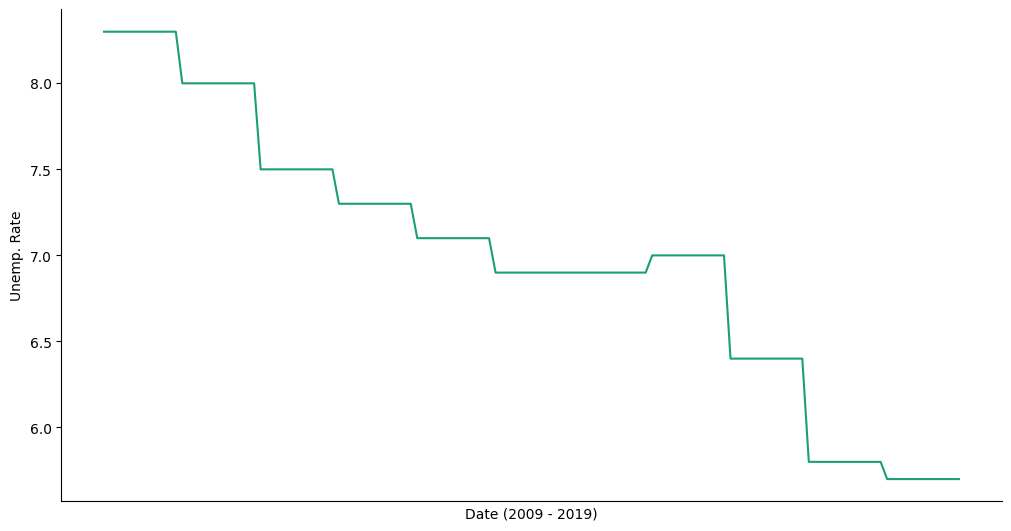

In [ ]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Unemp. Rate']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = econ_indicators.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xticks([])
plt.xlabel('Date (2009 - 2019)')
_ = plt.ylabel('Unemp. Rate')

#### CPI

In [ ]:
CPI_df = pd.read_csv(f"{FILES_LOCATION}/CPI.csv")
CPI_df

,date,ATOM_V41693242,CPIW,CPI_COMMON,CPI_MEDIAN,CPI_TRIM,STATIC_CPIXFET,STATIC_TOTALCPICHANGE
0,1995-01-01,NaN,1.7,1.2,1.8,1.8,2.2,0.6
1,1995-02-01,NaN,1.7,1.2,1.8,1.9,1.8,1.9
2,1995-03-01,NaN,1.9,1.5,1.8,2.0,2.1,2.1
3,1995-04-01,NaN,2.0,1.5,2.0,2.1,2.1,2.5
4,1995-05-01,NaN,2.2,1.9,2.1,2.3,2.6,2.9
...,...,...,...,...,...,...,...,...
340,2023-05-01,3.7,4.7,5.2,4.0,3.8,4.0,3.4
341,2023-06-01,3.2,4.4,5.1,3.9,3.7,3.5,2.8
342,2023-07-01,3.2,4.2,4.8,3.9,3.6,3.4,3.3
343,2023-08-01,3.3,4.5,4.8,4.1,3.9,3.6,4.0


In [ ]:
CPI_df['date'] = CPI_df['date'].apply(year_changer)
CPI_df

,date,ATOM_V41693242,CPIW,CPI_COMMON,CPI_MEDIAN,CPI_TRIM,STATIC_CPIXFET,STATIC_TOTALCPICHANGE
0,1995-01,NaN,1.7,1.2,1.8,1.8,2.2,0.6
1,1995-02,NaN,1.7,1.2,1.8,1.9,1.8,1.9
2,1995-03,NaN,1.9,1.5,1.8,2.0,2.1,2.1
3,1995-04,NaN,2.0,1.5,2.0,2.1,2.1,2.5
4,1995-05,NaN,2.2,1.9,2.1,2.3,2.6,2.9
...,...,...,...,...,...,...,...,...
340,2023-05,3.7,4.7,5.2,4.0,3.8,4.0,3.4
341,2023-06,3.2,4.4,5.1,3.9,3.7,3.5,2.8
342,2023-07,3.2,4.2,4.8,3.9,3.6,3.4,3.3
343,2023-08,3.3,4.5,4.8,4.1,3.9,3.6,4.0


In [ ]:
CPI_df['date'] = CPI_df['date'].astype(str)
CPI_df = CPI_df[(CPI_df['date'].str[0:4].astype(int) >= 2009) & (CPI_df['date'].str[0:4].astype(int) <= 2019)].reset_index().drop(columns='index')
CPI_df

,date,ATOM_V41693242,CPIW,CPI_COMMON,CPI_MEDIAN,CPI_TRIM,STATIC_CPIXFET,STATIC_TOTALCPICHANGE
0,2009-01,1.9,2.3,3.0,2.5,2.4,1.2,1.1
1,2009-02,1.9,2.4,3.1,2.5,2.4,1.3,1.4
2,2009-03,2.0,2.4,3.2,2.5,2.4,1.4,1.2
3,2009-04,1.8,2.0,3.1,2.2,2.0,1.2,0.4
4,2009-05,2.0,2.1,3.3,2.2,2.0,1.3,0.1
...,...,...,...,...,...,...,...,...
127,2019-08,1.9,2.3,2.1,1.9,2.0,2.2,1.9
128,2019-09,1.9,2.3,2.4,1.9,2.0,2.1,1.9
129,2019-10,1.9,2.3,2.4,2.0,2.0,2.1,1.9
130,2019-11,1.9,2.4,2.5,2.1,2.1,2.1,2.2


In [ ]:
CPI_df = CPI_df.rename(columns={'date' : 'Date'})
CPI_df

,Date,ATOM_V41693242,CPIW,CPI_COMMON,CPI_MEDIAN,CPI_TRIM,STATIC_CPIXFET,STATIC_TOTALCPICHANGE
0,2009-01,1.9,2.3,3.0,2.5,2.4,1.2,1.1
1,2009-02,1.9,2.4,3.1,2.5,2.4,1.3,1.4
2,2009-03,2.0,2.4,3.2,2.5,2.4,1.4,1.2
3,2009-04,1.8,2.0,3.1,2.2,2.0,1.2,0.4
4,2009-05,2.0,2.1,3.3,2.2,2.0,1.3,0.1
...,...,...,...,...,...,...,...,...
127,2019-08,1.9,2.3,2.1,1.9,2.0,2.2,1.9
128,2019-09,1.9,2.3,2.4,1.9,2.0,2.1,1.9
129,2019-10,1.9,2.3,2.4,2.0,2.0,2.1,1.9
130,2019-11,1.9,2.4,2.5,2.1,2.1,2.1,2.2


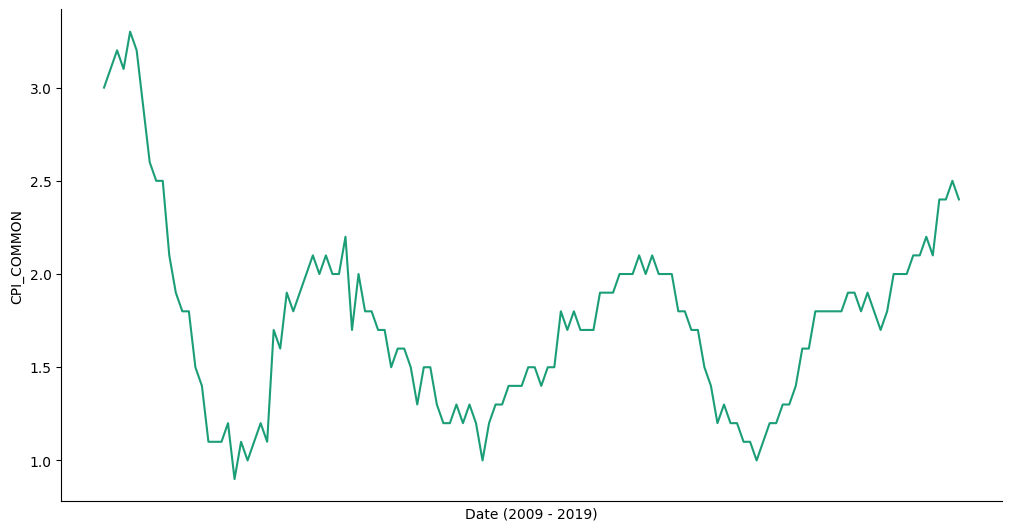

In [ ]:
# Too many dates to shoe on axis
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['CPI_COMMON']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = CPI_df.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xticks([])
plt.xlabel('Date (2009 - 2019)')
_ = plt.ylabel('CPI_COMMON')

#### GDP

In [ ]:
GDP_df = pd.read_csv(f"{FILES_LOCATION}/GDP.csv")
GDP_df

<ipython-input-24-200c8220df88>:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  GDP_df = pd.read_csv(f"{FILES_LOCATION}/GDP.csv")


,REF_DATE,GEO,DGUID,Seasonal adjustment,Prices,North American Industry Classification System (NAICS),UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1997-01,Canada,2016A000011124,Seasonally adjusted at annual rates,Chained (2012) dollars,All industries [T001],Dollars,81,millions,6,v65201210,1.1.1.1,1146254.0,NaN,NaN,NaN,0
1,1997-01,Canada,2016A000011124,Seasonally adjusted at annual rates,Chained (2012) dollars,Goods-producing industries [T002],Dollars,81,millions,6,v65201211,1.1.1.2,392172.0,NaN,NaN,NaN,0
2,1997-01,Canada,2016A000011124,Seasonally adjusted at annual rates,Chained (2012) dollars,Service-producing industries [T003],Dollars,81,millions,6,v65201212,1.1.1.3,753361.0,NaN,NaN,NaN,0
3,1997-01,Canada,2016A000011124,Seasonally adjusted at annual rates,Chained (2012) dollars,Business sector industries [T004],Dollars,81,millions,6,v65201213,1.1.1.4,NaN,..,NaN,NaN,0
4,1997-01,Canada,2016A000011124,Seasonally adjusted at annual rates,Chained (2012) dollars,"Business sector, goods [T005]",Dollars,81,millions,6,v65201214,1.1.1.5,NaN,..,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275515,2023-08,Canada,2016A000011124,Trading-day adjusted,2012 constant prices,Defence services [9111],Dollars,81,millions,6,v65202024,1.2.2.269,979.0,NaN,NaN,NaN,0
275516,2023-08,Canada,2016A000011124,Trading-day adjusted,2012 constant prices,Federal government public administration (exce...,Dollars,81,millions,6,v65202025,1.2.2.270,3360.0,NaN,NaN,NaN,0
275517,2023-08,Canada,2016A000011124,Trading-day adjusted,2012 constant prices,Provincial and territorial public administrati...,Dollars,81,millions,6,v65202026,1.2.2.271,2917.0,NaN,NaN,NaN,0
275518,2023-08,Canada,2016A000011124,Trading-day adjusted,2012 constant prices,"Local, municipal and regional public administr...",Dollars,81,millions,6,v65202027,1.2.2.272,3592.0,NaN,NaN,NaN,0


In [ ]:
# Keeping only data such that the NAICS data refers to all industries
GDP_df = GDP_df[GDP_df['North American Industry Classification System (NAICS)'] == 'All industries [T001]'].reset_index().drop(columns=['index'])
GDP_df

,REF_DATE,GEO,DGUID,Seasonal adjustment,Prices,North American Industry Classification System (NAICS),UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1997-01,Canada,2016A000011124,Seasonally adjusted at annual rates,Chained (2012) dollars,All industries [T001],Dollars,81,millions,6,v65201210,1.1.1.1,1146254.0,NaN,NaN,NaN,0
1,1997-01,Canada,2016A000011124,Seasonally adjusted at annual rates,2012 constant prices,All industries [T001],Dollars,81,millions,6,v65201483,1.1.2.1,1161269.0,NaN,NaN,NaN,0
2,1997-01,Canada,2016A000011124,Trading-day adjusted,2012 constant prices,All industries [T001],Dollars,81,millions,6,v65201756,1.2.2.1,92165.0,NaN,NaN,NaN,0
3,1997-02,Canada,2016A000011124,Seasonally adjusted at annual rates,Chained (2012) dollars,All industries [T001],Dollars,81,millions,6,v65201210,1.1.1.1,1153493.0,NaN,NaN,NaN,0
4,1997-02,Canada,2016A000011124,Seasonally adjusted at annual rates,2012 constant prices,All industries [T001],Dollars,81,millions,6,v65201483,1.1.2.1,1168576.0,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,2023-07,Canada,2016A000011124,Seasonally adjusted at annual rates,2012 constant prices,All industries [T001],Dollars,81,millions,6,v65201483,1.1.2.1,2093784.0,NaN,NaN,NaN,0
956,2023-07,Canada,2016A000011124,Trading-day adjusted,2012 constant prices,All industries [T001],Dollars,81,millions,6,v65201756,1.2.2.1,167739.0,NaN,NaN,NaN,0
957,2023-08,Canada,2016A000011124,Seasonally adjusted at annual rates,Chained (2012) dollars,All industries [T001],Dollars,81,millions,6,v65201210,1.1.1.1,2082521.0,NaN,NaN,NaN,0
958,2023-08,Canada,2016A000011124,Seasonally adjusted at annual rates,2012 constant prices,All industries [T001],Dollars,81,millions,6,v65201483,1.1.2.1,2093816.0,NaN,NaN,NaN,0


In [ ]:
# Check redundant columns
see_redundant(GDP_df)

['REF_DATE']: ['1997-01', '1997-02', '1997-03', '1997-04', '1997-05', '1997-06', '1997-07', '1997-08', '1997-09', '1997-10', '1997-11', '1997-12', '1998-01', '1998-02', '1998-03', '1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09', '1998-10', '1998-11', '1998-12', '1999-01', '1999-02', '1999-03', '1999-04', '1999-05', '1999-06', '1999-07', '1999-08', '1999-09', '1999-10', '1999-11', '1999-12', '2000-01', '2000-02', '2000-03', '2000-04', '2000-05', '2000-06', '2000-07', '2000-08', '2000-09', '2000-10', '2000-11', '2000-12', '2001-01', '2001-02', '2001-03', '2001-04', '2001-05', '2001-06', '2001-07', '2001-08', '2001-09', '2001-10', '2001-11', '2001-12', '2002-01', '2002-02', '2002-03', '2002-04', '2002-05', '2002-06', '2002-07', '2002-08', '2002-09', '2002-10', '2002-11', '2002-12', '2003-01', '2003-02', '2003-03', '2003-04', '2003-05', '2003-06', '2003-07', '2003-08', '2003-09', '2003-10', '2003-11', '2003-12', '2004-01', '2004-02', '2004-03', '2004-04', '2004-05', '2004-

In [ ]:
# Remove redundant columns
GDP_df = GDP_df.drop(columns=['GEO', 'DGUID', 'North American Industry Classification System (NAICS)', 'UOM', 'UOM_ID', 'SCALAR_FACTOR',
                              'SCALAR_ID', 'STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS', 'VECTOR', 'COORDINATE'])
GDP_df

,REF_DATE,Seasonal adjustment,Prices,VALUE
0,1997-01,Seasonally adjusted at annual rates,Chained (2012) dollars,1146254.0
1,1997-01,Seasonally adjusted at annual rates,2012 constant prices,1161269.0
2,1997-01,Trading-day adjusted,2012 constant prices,92165.0
3,1997-02,Seasonally adjusted at annual rates,Chained (2012) dollars,1153493.0
4,1997-02,Seasonally adjusted at annual rates,2012 constant prices,1168576.0
...,...,...,...,...
955,2023-07,Seasonally adjusted at annual rates,2012 constant prices,2093784.0
956,2023-07,Trading-day adjusted,2012 constant prices,167739.0
957,2023-08,Seasonally adjusted at annual rates,Chained (2012) dollars,2082521.0
958,2023-08,Seasonally adjusted at annual rates,2012 constant prices,2093816.0


In [ ]:
GDP_df = GDP_df.rename(columns={'VALUE': 'GDP (millions 2012 Constant Price)'})
GDP_df

,REF_DATE,Seasonal adjustment,Prices,GDP (millions 2012 Constant Price)
0,1997-01,Seasonally adjusted at annual rates,Chained (2012) dollars,1146254.0
1,1997-01,Seasonally adjusted at annual rates,2012 constant prices,1161269.0
2,1997-01,Trading-day adjusted,2012 constant prices,92165.0
3,1997-02,Seasonally adjusted at annual rates,Chained (2012) dollars,1153493.0
4,1997-02,Seasonally adjusted at annual rates,2012 constant prices,1168576.0
...,...,...,...,...
955,2023-07,Seasonally adjusted at annual rates,2012 constant prices,2093784.0
956,2023-07,Trading-day adjusted,2012 constant prices,167739.0
957,2023-08,Seasonally adjusted at annual rates,Chained (2012) dollars,2082521.0
958,2023-08,Seasonally adjusted at annual rates,2012 constant prices,2093816.0


In [ ]:
# Since housing data is seasonally-adjusted, we keep only seasonally adjusted data at annual rates
GDP_df = GDP_df[GDP_df['Seasonal adjustment'] == 'Seasonally adjusted at annual rates'].reset_index().drop(columns='index')
GDP_df

,REF_DATE,Seasonal adjustment,Prices,GDP (millions 2012 Constant Price)
0,1997-01,Seasonally adjusted at annual rates,Chained (2012) dollars,1146254.0
1,1997-01,Seasonally adjusted at annual rates,2012 constant prices,1161269.0
2,1997-02,Seasonally adjusted at annual rates,Chained (2012) dollars,1153493.0
3,1997-02,Seasonally adjusted at annual rates,2012 constant prices,1168576.0
4,1997-03,Seasonally adjusted at annual rates,Chained (2012) dollars,1153375.0
...,...,...,...,...
635,2023-06,Seasonally adjusted at annual rates,2012 constant prices,2091606.0
636,2023-07,Seasonally adjusted at annual rates,Chained (2012) dollars,2081768.0
637,2023-07,Seasonally adjusted at annual rates,2012 constant prices,2093784.0
638,2023-08,Seasonally adjusted at annual rates,Chained (2012) dollars,2082521.0


In [ ]:
# Since there is no significant difference between 'Chained (2012) dollars' and '2012 constant prices', we arbitrarily kept '2012 constant prices'
GDP_df = GDP_df[GDP_df['Prices'] == '2012 constant prices'].reset_index().drop(columns='index')
GDP_df

,REF_DATE,Seasonal adjustment,Prices,GDP (millions 2012 Constant Price)
0,1997-01,Seasonally adjusted at annual rates,2012 constant prices,1161269.0
1,1997-02,Seasonally adjusted at annual rates,2012 constant prices,1168576.0
2,1997-03,Seasonally adjusted at annual rates,2012 constant prices,1168456.0
3,1997-04,Seasonally adjusted at annual rates,2012 constant prices,1176368.0
4,1997-05,Seasonally adjusted at annual rates,2012 constant prices,1180541.0
...,...,...,...,...
315,2023-04,Seasonally adjusted at annual rates,2012 constant prices,2092622.0
316,2023-05,Seasonally adjusted at annual rates,2012 constant prices,2095744.0
317,2023-06,Seasonally adjusted at annual rates,2012 constant prices,2091606.0
318,2023-07,Seasonally adjusted at annual rates,2012 constant prices,2093784.0


In [ ]:
GDP_df = GDP_df.rename(columns= {'REF_DATE' : 'Date'})
GDP_df

,Date,Seasonal adjustment,Prices,GDP (millions 2012 Constant Price)
0,1997-01,Seasonally adjusted at annual rates,2012 constant prices,1161269.0
1,1997-02,Seasonally adjusted at annual rates,2012 constant prices,1168576.0
2,1997-03,Seasonally adjusted at annual rates,2012 constant prices,1168456.0
3,1997-04,Seasonally adjusted at annual rates,2012 constant prices,1176368.0
4,1997-05,Seasonally adjusted at annual rates,2012 constant prices,1180541.0
...,...,...,...,...
315,2023-04,Seasonally adjusted at annual rates,2012 constant prices,2092622.0
316,2023-05,Seasonally adjusted at annual rates,2012 constant prices,2095744.0
317,2023-06,Seasonally adjusted at annual rates,2012 constant prices,2091606.0
318,2023-07,Seasonally adjusted at annual rates,2012 constant prices,2093784.0


In [ ]:
GDP_df = GDP_df.drop(columns=['Seasonal adjustment', 'Prices'])
GDP_df

,Date,GDP (millions 2012 Constant Price)
0,1997-01,1161269.0
1,1997-02,1168576.0
2,1997-03,1168456.0
3,1997-04,1176368.0
4,1997-05,1180541.0
...,...,...
315,2023-04,2092622.0
316,2023-05,2095744.0
317,2023-06,2091606.0
318,2023-07,2093784.0


In [ ]:
GDP_df = GDP_df[(GDP_df['Date'].str[:4].astype(int) >= 2009) & (GDP_df['Date'].str[:4].astype(int) <= 2019)]
GDP_df

,Date,GDP (millions 2012 Constant Price)
144,2009-01,1582918.0
145,2009-02,1576917.0
146,2009-03,1566404.0
147,2009-04,1561546.0
148,2009-05,1558576.0
...,...,...
271,2019-08,2004013.0
272,2019-09,2005880.0
273,2019-10,2009643.0
274,2019-11,2008667.0


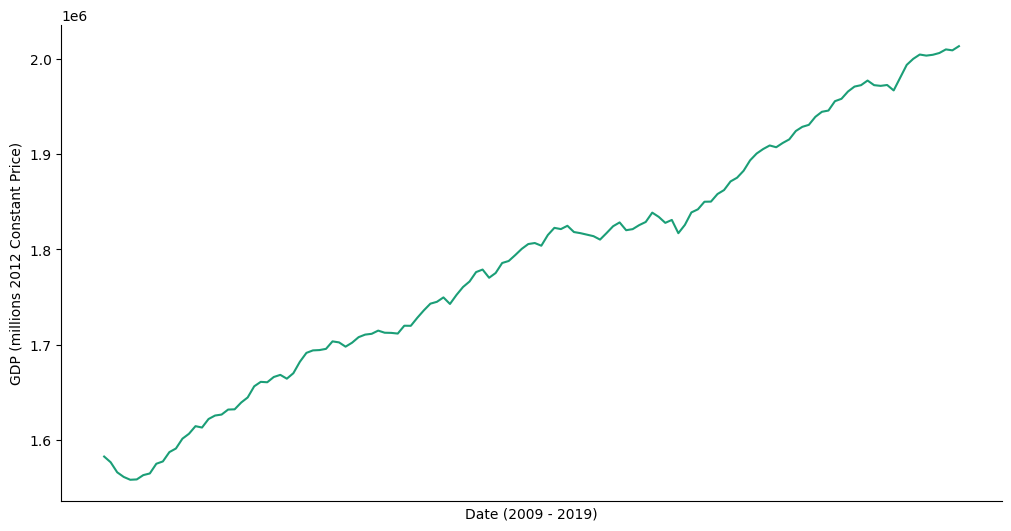

In [ ]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['GDP (millions 2012 Constant Price)']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = GDP_df.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xticks([])
plt.xlabel('Date (2009 - 2019)')
_ = plt.ylabel('GDP (millions 2012 Constant Price)')

#### Average Housing Price

In [ ]:
average_housing_prices_df = pd.read_excel(f"{FILES_LOCATION}/average_housing_prices.xlsx", sheet_name='Chart 4')
average_housing_prices_df

,Date,Average*,MLS® HPI Aggregate Composite Benchmark†,Unnamed: 3,*Actual (not seasonally adjusted)
0,2005-01-01,229463.20024,241000,NaN,† Seasonally adjusted
1,2005-02-01,238300.88841,241800,NaN,NaN
2,2005-03-01,243894.48534,242600,NaN,NaN
3,2005-04-01,247988.52189,243300,NaN,NaN
4,2005-05-01,250835.77340,243800,NaN,NaN
...,...,...,...,...,...
220,2023-05-01,728534.11893,733200,NaN,NaN
221,2023-06-01,708951.42914,746300,NaN,NaN
222,2023-07-01,668696.96617,753600,NaN,NaN
223,2023-08-01,649872.91871,756000,NaN,NaN


In [ ]:
# Drop false columns
average_housing_prices_df = average_housing_prices_df.iloc[:, [0, 1]]
average_housing_prices_df

,Date,Average*
0,2005-01-01,229463.20024
1,2005-02-01,238300.88841
2,2005-03-01,243894.48534
3,2005-04-01,247988.52189
4,2005-05-01,250835.77340
...,...,...
220,2023-05-01,728534.11893
221,2023-06-01,708951.42914
222,2023-07-01,668696.96617
223,2023-08-01,649872.91871


In [ ]:
average_housing_prices_type_df = pd.read_excel(f"{FILES_LOCATION}/average_housing_prices.xlsx", sheet_name='Chart 6')
average_housing_prices_type_df

,Date,Composite,One_storey,Two_storey,Townhouse,Apartment_unit,Unnamed: 6,Seasonally adjusted
0,2005-01-01,241000,208700,303900,202500,174500,NaN,NaN
1,2005-02-01,241800,209400,304300,203100,175600,NaN,NaN
2,2005-03-01,242600,210100,305300,203700,176400,NaN,NaN
3,2005-04-01,243300,211100,305800,204200,177200,NaN,NaN
4,2005-05-01,243800,211500,306400,204600,178100,NaN,NaN
...,...,...,...,...,...,...,...,...
220,2023-05-01,733200,616900,948100,670600,529900,NaN,NaN
221,2023-06-01,746300,628000,964700,681700,540800,NaN,NaN
222,2023-07-01,753600,635500,974100,687500,545300,NaN,NaN
223,2023-08-01,756000,636800,975000,693300,549500,NaN,NaN


In [ ]:
# Remove false columns
average_housing_prices_type_df = average_housing_prices_type_df.drop(columns=['Composite', 'Unnamed: 6', 'Seasonally adjusted'])
average_housing_prices_type_df

,Date,One_storey,Two_storey,Townhouse,Apartment_unit
0,2005-01-01,208700,303900,202500,174500
1,2005-02-01,209400,304300,203100,175600
2,2005-03-01,210100,305300,203700,176400
3,2005-04-01,211100,305800,204200,177200
4,2005-05-01,211500,306400,204600,178100
...,...,...,...,...,...
220,2023-05-01,616900,948100,670600,529900
221,2023-06-01,628000,964700,681700,540800
222,2023-07-01,635500,974100,687500,545300
223,2023-08-01,636800,975000,693300,549500


In [ ]:
# Merge these data
average_housing_df = pd.merge(average_housing_prices_df, average_housing_prices_type_df, on='Date')
average_housing_df

,Date,Average*,One_storey,Two_storey,Townhouse,Apartment_unit
0,2005-01-01,229463.20024,208700,303900,202500,174500
1,2005-02-01,238300.88841,209400,304300,203100,175600
2,2005-03-01,243894.48534,210100,305300,203700,176400
3,2005-04-01,247988.52189,211100,305800,204200,177200
4,2005-05-01,250835.77340,211500,306400,204600,178100
...,...,...,...,...,...,...
220,2023-05-01,728534.11893,616900,948100,670600,529900
221,2023-06-01,708951.42914,628000,964700,681700,540800
222,2023-07-01,668696.96617,635500,974100,687500,545300
223,2023-08-01,649872.91871,636800,975000,693300,549500


In [ ]:
average_housing_df.columns

Index(['Date', '  Average*', 'One_storey', 'Two_storey', 'Townhouse',
       'Apartment_unit'],
      dtype='object')

In [ ]:
# Rename columns
average_housing_df = average_housing_df.rename(columns={'  Average*': 'Average price', "One_storey": "One storey price",
                                                        "Two_storey": "Two storey price", 'Townhouse': "Townhouse price",
                                                        "Apartment_unit": "Apartment price"})
average_housing_df

,Date,Average price,One storey price,Two storey price,Townhouse price,Apartment price
0,2005-01-01,229463.20024,208700,303900,202500,174500
1,2005-02-01,238300.88841,209400,304300,203100,175600
2,2005-03-01,243894.48534,210100,305300,203700,176400
3,2005-04-01,247988.52189,211100,305800,204200,177200
4,2005-05-01,250835.77340,211500,306400,204600,178100
...,...,...,...,...,...,...
220,2023-05-01,728534.11893,616900,948100,670600,529900
221,2023-06-01,708951.42914,628000,964700,681700,540800
222,2023-07-01,668696.96617,635500,974100,687500,545300
223,2023-08-01,649872.91871,636800,975000,693300,549500


In [ ]:
# Round decimal places
def average_rounder(val):
  return round(val, 2)

average_housing_df['Average price'] = average_housing_df['Average price'].apply(average_rounder)
average_housing_df

,Date,Average price,One storey price,Two storey price,Townhouse price,Apartment price
0,2005-01-01,229463.20,208700,303900,202500,174500
1,2005-02-01,238300.89,209400,304300,203100,175600
2,2005-03-01,243894.49,210100,305300,203700,176400
3,2005-04-01,247988.52,211100,305800,204200,177200
4,2005-05-01,250835.77,211500,306400,204600,178100
...,...,...,...,...,...,...
220,2023-05-01,728534.12,616900,948100,670600,529900
221,2023-06-01,708951.43,628000,964700,681700,540800
222,2023-07-01,668696.97,635500,974100,687500,545300
223,2023-08-01,649872.92,636800,975000,693300,549500


In [ ]:
average_housing_df['Date'] = average_housing_df['Date'].astype(str)
average_housing_df['Date'] = average_housing_df['Date'].apply(year_changer)
average_housing_df

,Date,Average price,One storey price,Two storey price,Townhouse price,Apartment price
0,2005-01,229463.20,208700,303900,202500,174500
1,2005-02,238300.89,209400,304300,203100,175600
2,2005-03,243894.49,210100,305300,203700,176400
3,2005-04,247988.52,211100,305800,204200,177200
4,2005-05,250835.77,211500,306400,204600,178100
...,...,...,...,...,...,...
220,2023-05,728534.12,616900,948100,670600,529900
221,2023-06,708951.43,628000,964700,681700,540800
222,2023-07,668696.97,635500,974100,687500,545300
223,2023-08,649872.92,636800,975000,693300,549500


In [ ]:
average_housing_df = average_housing_df[(average_housing_df['Date'].str[:4].astype(int) >= 2009) & (average_housing_df['Date'].str[:4].astype(int) <= 2019)]
average_housing_df

,Date,Average price,One storey price,Two storey price,Townhouse price,Apartment price
48,2009-01,275712.91,266900,365800,265200,225700
49,2009-02,284924.45,264300,362100,263100,224400
50,2009-03,290405.99,261200,360500,260900,223700
51,2009-04,307191.39,262700,362100,260300,224800
52,2009-05,320489.45,264100,365800,261100,226500
...,...,...,...,...,...,...
175,2019-08,494477.32,435100,666500,479900,415700
176,2019-09,513180.82,437700,670300,483400,419500
177,2019-10,525979.64,440300,674600,486800,421700
178,2019-11,529926.62,442000,676600,489700,425900


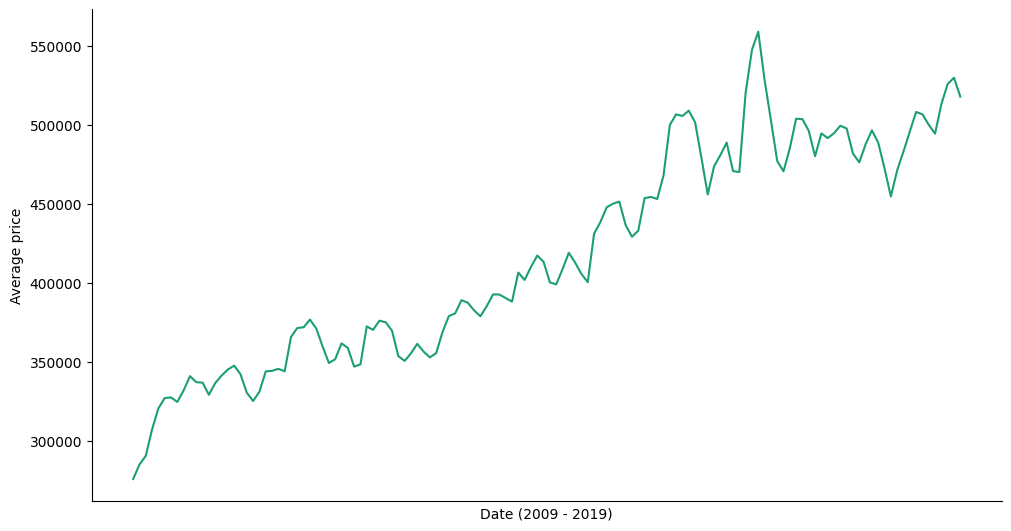

In [ ]:
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Average price']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = average_housing_df.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xticks([])
plt.xlabel('Date (2009 - 2019)')
_ = plt.ylabel('Average price')

#### Interest Rate

In [ ]:
interest_rate_df = pd.read_csv(f"{FILES_LOCATION}/interest_rate.csv").drop(columns=['Unnamed: 0'])
interest_rate_df

,REF_DATE,Financial market statistics,VALUE
0,1960-07-22,Overnight money market financing,NaN
1,1960-07-22,"Government of Canada benchmark bond yields, 2 ...",NaN
2,1960-07-22,"Government of Canada benchmark bond yields, 3 ...",NaN
3,1960-07-22,"Government of Canada benchmark bond yields, 5 ...",NaN
4,1960-07-22,"Government of Canada benchmark bond yields, 7 ...",NaN
...,...,...,...
633435,2022-05-02,"Prime corporate paper rate, 3-month",NaN
633436,2022-05-02,"Operating band, low",1.00
633437,2022-05-02,"Operating band, high",1.25
633438,2022-05-02,Bank rate,1.25


In [ ]:
# Keep only Bank Rate financial market rows
interest_rate_df = interest_rate_df[interest_rate_df['Financial market statistics'] == 'Bank rate']
interest_rate_df

,REF_DATE,Financial market statistics,VALUE
25,1960-07-22,Bank rate,NaN
52,1960-07-23,Bank rate,NaN
79,1960-07-24,Bank rate,NaN
106,1960-07-25,Bank rate,NaN
133,1960-07-26,Bank rate,NaN
...,...,...,...
633330,2022-04-28,Bank rate,1.25
633357,2022-04-29,Bank rate,1.25
633384,2022-04-30,Bank rate,NaN
633411,2022-05-01,Bank rate,NaN


In [ ]:
# Drop nan
interest_rate_df = interest_rate_df.dropna().reset_index().drop(columns='index')
interest_rate_df

,REF_DATE,Financial market statistics,VALUE
0,1960-07-27,Bank rate,3.44
1,1960-07-28,Bank rate,3.17
2,1960-07-29,Bank rate,3.17
3,1960-08-01,Bank rate,3.17
4,1960-08-02,Bank rate,3.17
...,...,...,...
16109,2022-04-26,Bank rate,1.25
16110,2022-04-27,Bank rate,1.25
16111,2022-04-28,Bank rate,1.25
16112,2022-04-29,Bank rate,1.25


In [ ]:
# Remove unnecessary columns
interest_rate_df = interest_rate_df.drop(columns=['Financial market statistics'])
interest_rate_df

,REF_DATE,VALUE
0,1960-07-27,3.44
1,1960-07-28,3.17
2,1960-07-29,3.17
3,1960-08-01,3.17
4,1960-08-02,3.17
...,...,...
16109,2022-04-26,1.25
16110,2022-04-27,1.25
16111,2022-04-28,1.25
16112,2022-04-29,1.25


In [ ]:
# Rename columns
interest_rate_df = interest_rate_df.rename(columns={"VALUE": "interest rate", "REF_DATE" : "Date"})
interest_rate_df

,Date,interest rate
0,1960-07-27,3.44
1,1960-07-28,3.17
2,1960-07-29,3.17
3,1960-08-01,3.17
4,1960-08-02,3.17
...,...,...
16109,2022-04-26,1.25
16110,2022-04-27,1.25
16111,2022-04-28,1.25
16112,2022-04-29,1.25


In [ ]:
interest_rate_df['Date'] = interest_rate_df['Date'].apply(year_changer)
interest_rate_df

,Date,interest rate
0,1960-07,3.44
1,1960-07,3.17
2,1960-07,3.17
3,1960-08,3.17
4,1960-08,3.17
...,...,...
16109,2022-04,1.25
16110,2022-04,1.25
16111,2022-04,1.25
16112,2022-04,1.25


In [ ]:
interest_rate_df = interest_rate_df[(interest_rate_df['Date'].str[:4].astype(int) >= 2009) & (interest_rate_df['Date'].str[:4].astype(int) <= 2019)]
interest_rate_df

,Date,interest rate
12636,2009-01,1.75
12637,2009-01,1.75
12638,2009-01,1.75
12639,2009-01,1.75
12640,2009-01,1.75
...,...,...
15500,2019-12,2.00
15501,2019-12,2.00
15502,2019-12,2.00
15503,2019-12,2.00


In [ ]:
interest_rate_df = interest_rate_df.groupby(['Date']).mean().reset_index()
interest_rate_df

,Date,interest rate
0,2009-01,1.545455
1,2009-02,1.250000
2,2009-03,0.772727
3,2009-04,0.659091
4,2009-05,0.500000
...,...,...
127,2019-08,2.000000
128,2019-09,2.000000
129,2019-10,2.000000
130,2019-11,2.000000


In [ ]:
interest_rate_df['interest rate'] = interest_rate_df['interest rate'].apply(lambda x: round(x, 2))
interest_rate_df

,Date,interest rate
0,2009-01,1.55
1,2009-02,1.25
2,2009-03,0.77
3,2009-04,0.66
4,2009-05,0.50
...,...,...
127,2019-08,2.00
128,2019-09,2.00
129,2019-10,2.00
130,2019-11,2.00


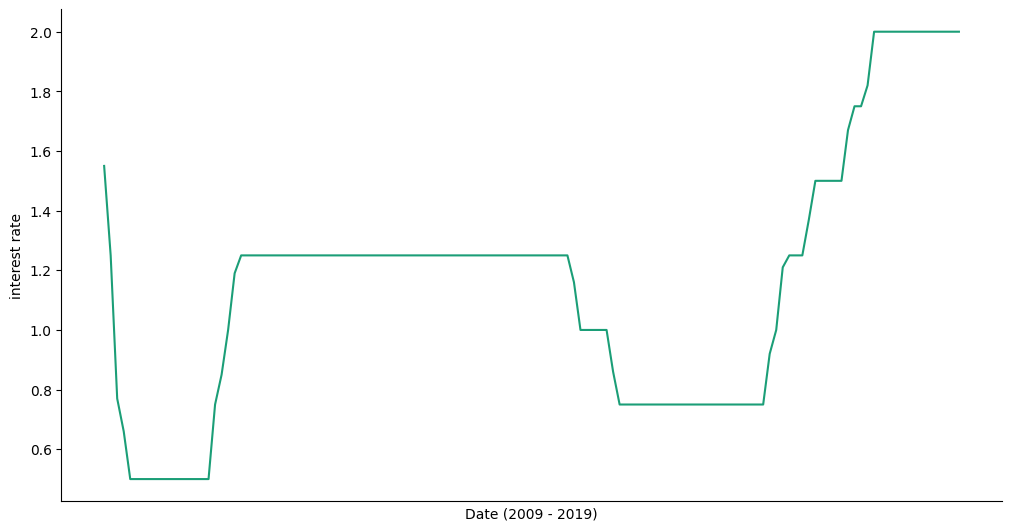

In [ ]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['interest rate']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = interest_rate_df.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xticks([])
plt.xlabel('Date (2009 - 2019)')
_ = plt.ylabel('interest rate')

#### Money Market (NOT USING)

In [ ]:
# Not actually using this. Not sure what this data means precisely
money_market_df = pd.read_csv(f"{FILES_LOCATION}/money_market.csv")
money_market_df

,REF_DATE,GEO,DGUID,Financial market statistics,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1960-07-22,Canada,2016A000011124,Overnight money market financing,Percent,239,units,0,v39050,1.12,NaN,..,NaN,NaN,4
1,1960-07-22,Canada,2016A000011124,"Government of Canada benchmark bond yields, 2 ...",Percent,239,units,0,v39051,1.13,NaN,..,NaN,NaN,2
2,1960-07-22,Canada,2016A000011124,"Government of Canada benchmark bond yields, 3 ...",Percent,239,units,0,v39052,1.14,NaN,..,NaN,NaN,2
3,1960-07-22,Canada,2016A000011124,"Government of Canada benchmark bond yields, 5 ...",Percent,239,units,0,v39053,1.15,NaN,..,NaN,NaN,2
4,1960-07-22,Canada,2016A000011124,"Government of Canada benchmark bond yields, 7 ...",Percent,239,units,0,v39054,1.16,NaN,..,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648420,2023-11-08,Canada,2016A000011124,"Prime corporate paper rate, 3-month",Percent,239,units,0,v39074,1.34,NaN,..,NaN,t,2
648421,2023-11-08,Canada,2016A000011124,"Operating band, low",Percent,239,units,0,v39076,1.36,5.00,NaN,NaN,NaN,3
648422,2023-11-08,Canada,2016A000011124,"Operating band, high",Percent,239,units,0,v39077,1.37,5.25,NaN,NaN,NaN,3
648423,2023-11-08,Canada,2016A000011124,Bank rate,Percent,239,units,0,v39078,1.38,5.25,NaN,NaN,NaN,3


In [ ]:
money_market_df['Financial market statistics'].unique()

array(['Overnight money market financing',
       'Government of Canada benchmark bond yields, 2 year',
       'Government of Canada benchmark bond yields, 3 year',
       'Government of Canada benchmark bond yields, 5 year',
       'Government of Canada benchmark bond yields, 7 year',
       'Government of Canada benchmark bond yields, 10 year',
       'Government of Canada benchmark bond yields, long term',
       'Real return benchmark bond yield, long term',
       'Government of Canada marketable bonds, 1 to 3 years',
       'Government of Canada marketable bonds, 3 to 5 years',
       'Government of Canada marketable bonds, 5 to 10 years',
       'Government of Canada marketable bonds, over 10 years',
       'Treasury Bills, 1-month', 'Treasury Bills, 2-month',
       'Treasury Bills, 3-month', 'Treasury Bills, 6-month',
       'Treasury Bills, 1-year', "Bankers' acceptances rate, 1-month",
       "Bankers' acceptances rate, 2-month",
       "Bankers' acceptances rate, 3-month",


#### New Housing Index (Nbr of new housing constructed per year)

In [ ]:
new_housing_df = pd.read_csv(f"{FILES_LOCATION}/new_housing_price_index.csv")
new_housing_df

,REF_DATE,GEO,DGUID,New housing price indexes,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1981-01,Canada,2016A000011124,Total (house and land),"Index, 201612=100",347,units,0,v111955442,1.1,38.2,NaN,NaN,NaN,1
1,1981-01,Canada,2016A000011124,House only,"Index, 201612=100",347,units,0,v111955443,1.2,36.1,NaN,NaN,NaN,1
2,1981-01,Canada,2016A000011124,Land only,"Index, 201612=100",347,units,0,v111955444,1.3,40.6,E,NaN,NaN,1
3,1981-01,Atlantic Region,2016A00011,Total (house and land),"Index, 201612=100",347,units,0,v111955445,2.1,NaN,..,NaN,NaN,1
4,1981-01,Atlantic Region,2016A00011,House only,"Index, 201612=100",347,units,0,v111955446,2.2,NaN,..,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61555,2023-09,"Vancouver, British Columbia",2011S0503933,House only,"Index, 201612=100",347,units,0,v111955557,39.2,127.1,NaN,NaN,NaN,1
61556,2023-09,"Vancouver, British Columbia",2011S0503933,Land only,"Index, 201612=100",347,units,0,v111955558,39.3,121.6,E,NaN,NaN,1
61557,2023-09,"Victoria, British Columbia",2011S0503935,Total (house and land),"Index, 201612=100",347,units,0,v111955559,40.1,120.7,NaN,NaN,NaN,1
61558,2023-09,"Victoria, British Columbia",2011S0503935,House only,"Index, 201612=100",347,units,0,v111955560,40.2,126.5,NaN,NaN,NaN,1


In [ ]:
# Keep only Canada-wide data
new_housing_df = new_housing_df[new_housing_df['GEO'] == 'Canada'].reset_index().drop(columns='index')
new_housing_df

,REF_DATE,GEO,DGUID,New housing price indexes,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1981-01,Canada,2016A000011124,Total (house and land),"Index, 201612=100",347,units,0,v111955442,1.1,38.2,NaN,NaN,NaN,1
1,1981-01,Canada,2016A000011124,House only,"Index, 201612=100",347,units,0,v111955443,1.2,36.1,NaN,NaN,NaN,1
2,1981-01,Canada,2016A000011124,Land only,"Index, 201612=100",347,units,0,v111955444,1.3,40.6,E,NaN,NaN,1
3,1981-02,Canada,2016A000011124,Total (house and land),"Index, 201612=100",347,units,0,v111955442,1.1,38.7,NaN,NaN,NaN,1
4,1981-02,Canada,2016A000011124,House only,"Index, 201612=100",347,units,0,v111955443,1.2,36.5,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1534,2023-08,Canada,2016A000011124,House only,"Index, 201612=100",347,units,0,v111955443,1.2,128.1,NaN,NaN,NaN,1
1535,2023-08,Canada,2016A000011124,Land only,"Index, 201612=100",347,units,0,v111955444,1.3,117.0,E,NaN,NaN,1
1536,2023-09,Canada,2016A000011124,Total (house and land),"Index, 201612=100",347,units,0,v111955442,1.1,124.7,NaN,NaN,NaN,1
1537,2023-09,Canada,2016A000011124,House only,"Index, 201612=100",347,units,0,v111955443,1.2,127.8,NaN,NaN,NaN,1


In [ ]:
# Keep only Total price indexes
new_housing_df = new_housing_df[new_housing_df['New housing price indexes'] == 'Total (house and land)'].reset_index().drop(columns='index')
new_housing_df

,REF_DATE,GEO,DGUID,New housing price indexes,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1981-01,Canada,2016A000011124,Total (house and land),"Index, 201612=100",347,units,0,v111955442,1.1,38.2,NaN,NaN,NaN,1
1,1981-02,Canada,2016A000011124,Total (house and land),"Index, 201612=100",347,units,0,v111955442,1.1,38.7,NaN,NaN,NaN,1
2,1981-03,Canada,2016A000011124,Total (house and land),"Index, 201612=100",347,units,0,v111955442,1.1,39.3,NaN,NaN,NaN,1
3,1981-04,Canada,2016A000011124,Total (house and land),"Index, 201612=100",347,units,0,v111955442,1.1,39.9,NaN,NaN,NaN,1
4,1981-05,Canada,2016A000011124,Total (house and land),"Index, 201612=100",347,units,0,v111955442,1.1,40.6,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,2023-05,Canada,2016A000011124,Total (house and land),"Index, 201612=100",347,units,0,v111955442,1.1,124.9,NaN,NaN,NaN,1
509,2023-06,Canada,2016A000011124,Total (house and land),"Index, 201612=100",347,units,0,v111955442,1.1,125.0,NaN,NaN,NaN,1
510,2023-07,Canada,2016A000011124,Total (house and land),"Index, 201612=100",347,units,0,v111955442,1.1,124.9,NaN,NaN,NaN,1
511,2023-08,Canada,2016A000011124,Total (house and land),"Index, 201612=100",347,units,0,v111955442,1.1,125.0,NaN,NaN,NaN,1


In [ ]:
# Check redundant columns
see_redundant(new_housing_df)

['REF_DATE']: ['1981-01', '1981-02', '1981-03', '1981-04', '1981-05', '1981-06', '1981-07', '1981-08', '1981-09', '1981-10', '1981-11', '1981-12', '1982-01', '1982-02', '1982-03', '1982-04', '1982-05', '1982-06', '1982-07', '1982-08', '1982-09', '1982-10', '1982-11', '1982-12', '1983-01', '1983-02', '1983-03', '1983-04', '1983-05', '1983-06', '1983-07', '1983-08', '1983-09', '1983-10', '1983-11', '1983-12', '1984-01', '1984-02', '1984-03', '1984-04', '1984-05', '1984-06', '1984-07', '1984-08', '1984-09', '1984-10', '1984-11', '1984-12', '1985-01', '1985-02', '1985-03', '1985-04', '1985-05', '1985-06', '1985-07', '1985-08', '1985-09', '1985-10', '1985-11', '1985-12', '1986-01', '1986-02', '1986-03', '1986-04', '1986-05', '1986-06', '1986-07', '1986-08', '1986-09', '1986-10', '1986-11', '1986-12', '1987-01', '1987-02', '1987-03', '1987-04', '1987-05', '1987-06', '1987-07', '1987-08', '1987-09', '1987-10', '1987-11', '1987-12', '1988-01', '1988-02', '1988-03', '1988-04', '1988-05', '1988-

In [ ]:
# Drop unnecessary columns
new_housing_df = new_housing_df.drop(columns=['DGUID', 'UOM', 'UOM_ID', 'VECTOR', 'SCALAR_FACTOR', 'SCALAR_ID', 'COORDINATE',
                                              'STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS', 'GEO', 'New housing price indexes']).reset_index().drop(columns='index')
new_housing_df

,REF_DATE,VALUE
0,1981-01,38.2
1,1981-02,38.7
2,1981-03,39.3
3,1981-04,39.9
4,1981-05,40.6
...,...,...
508,2023-05,124.9
509,2023-06,125.0
510,2023-07,124.9
511,2023-08,125.0


In [ ]:
new_housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 513 entries, 0 to 512
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   REF_DATE  513 non-null    object 
 1   VALUE     513 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.1+ KB


In [ ]:
new_housing_df = new_housing_df.rename(columns= {'REF_DATE' : 'Date', "VALUE": "Housing index"})
new_housing_df

,Date,Housing index
0,1981-01,38.2
1,1981-02,38.7
2,1981-03,39.3
3,1981-04,39.9
4,1981-05,40.6
...,...,...
508,2023-05,124.9
509,2023-06,125.0
510,2023-07,124.9
511,2023-08,125.0


In [ ]:
# new_housing_df['Year'] = new_housing_df['Year'].astype(str).astype(int)
new_housing_df = new_housing_df[(new_housing_df['Date'].str[:4].astype(int) >= 2009) & (new_housing_df['Date'].str[:4].astype(int) <= 2019)].reset_index().drop(columns='index')
new_housing_df

,Date,Housing index
0,2009-01,87.0
1,2009-02,86.4
2,2009-03,86.0
3,2009-04,85.5
4,2009-05,85.4
...,...,...
127,2019-08,103.0
128,2019-09,103.2
129,2019-10,103.3
130,2019-11,103.2


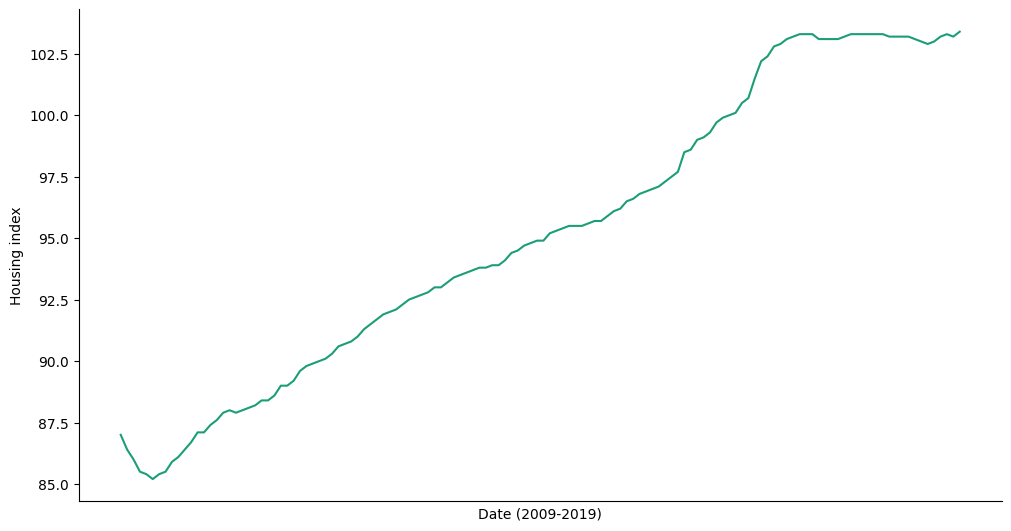

In [ ]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Housing index']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = new_housing_df.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date (2009-2019)')
plt.xticks([])
_ = plt.ylabel('Housing index')

#### Number of Families

In [ ]:
number_of_families_df = pd.read_excel(f'{FILES_LOCATION}/number_of_families.xlsx', sheet_name='Data')
number_of_families_df

,year,number (in millions)
0,2006,9.06
1,2007,9.17
2,2008,9.28
3,2009,9.38
4,2010,9.45
5,2011,9.56
6,2012,9.62
7,2013,9.70
8,2014,9.78
9,2015,9.83


In [ ]:
number_of_families_df = number_of_families_df.rename(columns= {'year' : 'Date', 'number (in millions)': 'Number of families'})
number_of_families_df

,Date,Number of families
0,2006,9.06
1,2007,9.17
2,2008,9.28
3,2009,9.38
4,2010,9.45
5,2011,9.56
6,2012,9.62
7,2013,9.70
8,2014,9.78
9,2015,9.83


In [ ]:
number_of_families_df['Number of families'] = number_of_families_df['Number of families'].apply(lambda x: int(x * 1_000_000))
number_of_families_df

,Date,Number of families
0,2006,9060000
1,2007,9170000
2,2008,9280000
3,2009,9380000
4,2010,9450000
5,2011,9560000
6,2012,9620000
7,2013,9700000
8,2014,9780000
9,2015,9830000


In [ ]:
number_of_families_df['Date'] = number_of_families_df['Date'].astype(str).astype(int)
number_of_families_df = number_of_families_df[(number_of_families_df['Date'] >= 2008) & (number_of_families_df['Date'] <= 2019)].reset_index().drop(columns='index')
number_of_families_df

,Date,Number of families
0,2008,9280000
1,2009,9380000
2,2010,9450000
3,2011,9560000
4,2012,9620000
5,2013,9700000
6,2014,9780000
7,2015,9830000
8,2016,9910000
9,2017,10030000


In [ ]:
diff_list = diff_cal(number_of_families_df['Number of families'])
diff_list
# for i in diff_list:
#   diff_dict.append(i, False)
# diff_dict = {i: False for i in diff_list}
# diff_dict

[100000,
 70000,
 110000,
 60000,
 80000,
 80000,
 50000,
 80000,
 120000,
 130000,
 120000]

In [ ]:
number_of_families_df['Number of families'] = number_of_families_df['Number of families'].apply(value_adder, diff_list=diff_list)
number_of_families_df

,Date,Number of families
0,2008,"[9280000, 9288333.33, 9296666.67, 9305000.0, 9..."
1,2009,"[9380000, 9385833.33, 9391666.67, 9397500.0, 9..."
2,2010,"[9450000, 9459166.67, 9468333.33, 9477500.0, 9..."
3,2011,"[9560000, 9565000.0, 9570000.0, 9575000.0, 958..."
4,2012,"[9620000, 9626666.67, 9633333.33, 9640000.0, 9..."
5,2013,"[9700000, 9706666.67, 9713333.33, 9720000.0, 9..."
6,2014,"[9780000, 9784166.67, 9788333.33, 9792500.0, 9..."
7,2015,"[9830000, 9836666.67, 9843333.33, 9850000.0, 9..."
8,2016,"[9910000, 9920000.0, 9930000.0, 9940000.0, 995..."
9,2017,"[10030000, 10040833.33, 10051666.67, 10062500...."


In [ ]:
number_of_families_df = number_of_families_df.drop(index=11)
number_of_families_df

,Date,Number of families
0,2008,"[9280000, 9288333.33, 9296666.67, 9305000.0, 9..."
1,2009,"[9380000, 9385833.33, 9391666.67, 9397500.0, 9..."
2,2010,"[9450000, 9459166.67, 9468333.33, 9477500.0, 9..."
3,2011,"[9560000, 9565000.0, 9570000.0, 9575000.0, 958..."
4,2012,"[9620000, 9626666.67, 9633333.33, 9640000.0, 9..."
5,2013,"[9700000, 9706666.67, 9713333.33, 9720000.0, 9..."
6,2014,"[9780000, 9784166.67, 9788333.33, 9792500.0, 9..."
7,2015,"[9830000, 9836666.67, 9843333.33, 9850000.0, 9..."
8,2016,"[9910000, 9920000.0, 9930000.0, 9940000.0, 995..."
9,2017,"[10030000, 10040833.33, 10051666.67, 10062500...."


In [ ]:
number_of_families_df['Date'] = number_of_families_df['Date'].apply(month_adder, add_1=True)
number_of_families_df

,Date,Number of families
0,"[2009-01, 2009-02, 2009-03, 2009-04, 2009-05, ...","[9280000, 9288333.33, 9296666.67, 9305000.0, 9..."
1,"[2010-01, 2010-02, 2010-03, 2010-04, 2010-05, ...","[9380000, 9385833.33, 9391666.67, 9397500.0, 9..."
2,"[2011-01, 2011-02, 2011-03, 2011-04, 2011-05, ...","[9450000, 9459166.67, 9468333.33, 9477500.0, 9..."
3,"[2012-01, 2012-02, 2012-03, 2012-04, 2012-05, ...","[9560000, 9565000.0, 9570000.0, 9575000.0, 958..."
4,"[2013-01, 2013-02, 2013-03, 2013-04, 2013-05, ...","[9620000, 9626666.67, 9633333.33, 9640000.0, 9..."
5,"[2014-01, 2014-02, 2014-03, 2014-04, 2014-05, ...","[9700000, 9706666.67, 9713333.33, 9720000.0, 9..."
6,"[2015-01, 2015-02, 2015-03, 2015-04, 2015-05, ...","[9780000, 9784166.67, 9788333.33, 9792500.0, 9..."
7,"[2016-01, 2016-02, 2016-03, 2016-04, 2016-05, ...","[9830000, 9836666.67, 9843333.33, 9850000.0, 9..."
8,"[2017-01, 2017-02, 2017-03, 2017-04, 2017-05, ...","[9910000, 9920000.0, 9930000.0, 9940000.0, 995..."
9,"[2018-01, 2018-02, 2018-03, 2018-04, 2018-05, ...","[10030000, 10040833.33, 10051666.67, 10062500...."


In [ ]:
number_of_families_df = number_of_families_df.explode(['Date', 'Number of families']).reset_index().drop(columns='index')
number_of_families_df

,Date,Number of families
0,2009-01,9280000
1,2009-02,9288333.33
2,2009-03,9296666.67
3,2009-04,9305000.0
4,2009-05,9313333.33
...,...,...
127,2019-08,10230000.0
128,2019-09,10240000.0
129,2019-10,10250000.0
130,2019-11,10260000.0


In [ ]:
number_of_families_df['Number of families'] = number_of_families_df['Number of families'].astype(int)
number_of_families_df

,Date,Number of families
0,2009-01,9280000
1,2009-02,9288333
2,2009-03,9296666
3,2009-04,9305000
4,2009-05,9313333
...,...,...
127,2019-08,10230000
128,2019-09,10240000
129,2019-10,10250000
130,2019-11,10260000


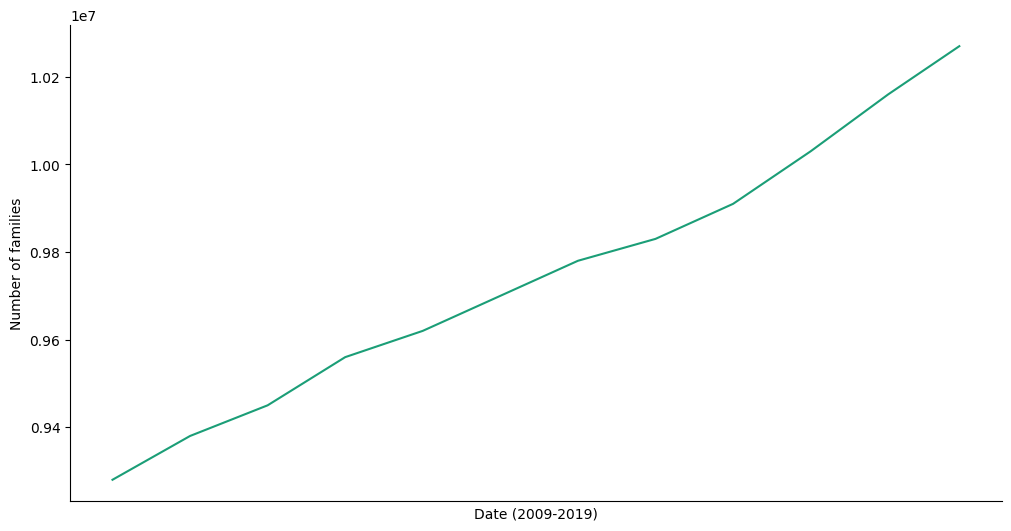

In [ ]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Number of families']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = number_of_families_df.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date (2009-2019)')
plt.xticks([])
_ = plt.ylabel('Number of families')

#### Number of Immigrants

In [ ]:
number_of_immigrants_df = pd.read_excel(f'{FILES_LOCATION}/number_of_immigrants.xlsx', sheet_name='Data')
number_of_immigrants_df

,year,number
0,2000 - 2001,252527
1,2001 - 2002,256405
2,2002 - 2003,199170
3,2003 - 2004,239083
4,2004 - 2005,244578
5,2005 - 2006,254374
6,2006 - 2007,238125
7,2007 - 2008,249622
8,2008 - 2009,245289
9,2009 - 2010,270581


In [ ]:
number_of_immigrants_df = number_of_immigrants_df.rename(columns={'number': 'Number of immigrants', 'year': 'Date'})
number_of_immigrants_df

,Date,Number of immigrants
0,2000 - 2001,252527
1,2001 - 2002,256405
2,2002 - 2003,199170
3,2003 - 2004,239083
4,2004 - 2005,244578
5,2005 - 2006,254374
6,2006 - 2007,238125
7,2007 - 2008,249622
8,2008 - 2009,245289
9,2009 - 2010,270581


In [ ]:
number_of_immigrants_df['Date'] = number_of_immigrants_df['Date'].apply(year_changer, num=4)
number_of_immigrants_df

,Date,Number of immigrants
0,2000,252527
1,2001,256405
2,2002,199170
3,2003,239083
4,2004,244578
5,2005,254374
6,2006,238125
7,2007,249622
8,2008,245289
9,2009,270581


In [ ]:
number_of_immigrants_df['Date'] = number_of_immigrants_df['Date'].astype(str).astype(int)
number_of_immigrants_df = number_of_immigrants_df[(number_of_immigrants_df['Date'] >= 2009) & (number_of_immigrants_df['Date'] <= 2019)].reset_index().drop(columns='index')
number_of_immigrants_df

,Date,Number of immigrants
0,2009,270581
1,2010,259110
2,2011,260036
3,2012,263101
4,2013,267924
5,2014,240763
6,2015,323192
7,2016,272707
8,2017,303325
9,2018,313601


In [ ]:
number_of_immigrants_df['Date'] = number_of_immigrants_df['Date'].apply(month_adder)
number_of_immigrants_df

,Date,Number of immigrants
0,"[2009-01, 2009-02, 2009-03, 2009-04, 2009-05, ...",270581
1,"[2010-01, 2010-02, 2010-03, 2010-04, 2010-05, ...",259110
2,"[2011-01, 2011-02, 2011-03, 2011-04, 2011-05, ...",260036
3,"[2012-01, 2012-02, 2012-03, 2012-04, 2012-05, ...",263101
4,"[2013-01, 2013-02, 2013-03, 2013-04, 2013-05, ...",267924
5,"[2014-01, 2014-02, 2014-03, 2014-04, 2014-05, ...",240763
6,"[2015-01, 2015-02, 2015-03, 2015-04, 2015-05, ...",323192
7,"[2016-01, 2016-02, 2016-03, 2016-04, 2016-05, ...",272707
8,"[2017-01, 2017-02, 2017-03, 2017-04, 2017-05, ...",303325
9,"[2018-01, 2018-02, 2018-03, 2018-04, 2018-05, ...",313601


In [ ]:
def immigrants_changer(val):
  new_val = int((val / 12))

  ls = [new_val] * 12

  return ls

number_of_immigrants_df['Number of immigrants'] = number_of_immigrants_df['Number of immigrants'].apply(immigrants_changer)
number_of_immigrants_df

,Date,Number of immigrants
0,"[2009-01, 2009-02, 2009-03, 2009-04, 2009-05, ...","[22548, 22548, 22548, 22548, 22548, 22548, 225..."
1,"[2010-01, 2010-02, 2010-03, 2010-04, 2010-05, ...","[21592, 21592, 21592, 21592, 21592, 21592, 215..."
2,"[2011-01, 2011-02, 2011-03, 2011-04, 2011-05, ...","[21669, 21669, 21669, 21669, 21669, 21669, 216..."
3,"[2012-01, 2012-02, 2012-03, 2012-04, 2012-05, ...","[21925, 21925, 21925, 21925, 21925, 21925, 219..."
4,"[2013-01, 2013-02, 2013-03, 2013-04, 2013-05, ...","[22327, 22327, 22327, 22327, 22327, 22327, 223..."
5,"[2014-01, 2014-02, 2014-03, 2014-04, 2014-05, ...","[20063, 20063, 20063, 20063, 20063, 20063, 200..."
6,"[2015-01, 2015-02, 2015-03, 2015-04, 2015-05, ...","[26932, 26932, 26932, 26932, 26932, 26932, 269..."
7,"[2016-01, 2016-02, 2016-03, 2016-04, 2016-05, ...","[22725, 22725, 22725, 22725, 22725, 22725, 227..."
8,"[2017-01, 2017-02, 2017-03, 2017-04, 2017-05, ...","[25277, 25277, 25277, 25277, 25277, 25277, 252..."
9,"[2018-01, 2018-02, 2018-03, 2018-04, 2018-05, ...","[26133, 26133, 26133, 26133, 26133, 26133, 261..."


In [ ]:
number_of_immigrants_df = number_of_immigrants_df.explode(['Date', 'Number of immigrants']).reset_index().drop(columns='index')
number_of_immigrants_df

,Date,Number of immigrants
0,2009-01,22548
1,2009-02,22548
2,2009-03,22548
3,2009-04,22548
4,2009-05,22548
...,...,...
127,2019-08,23679
128,2019-09,23679
129,2019-10,23679
130,2019-11,23679


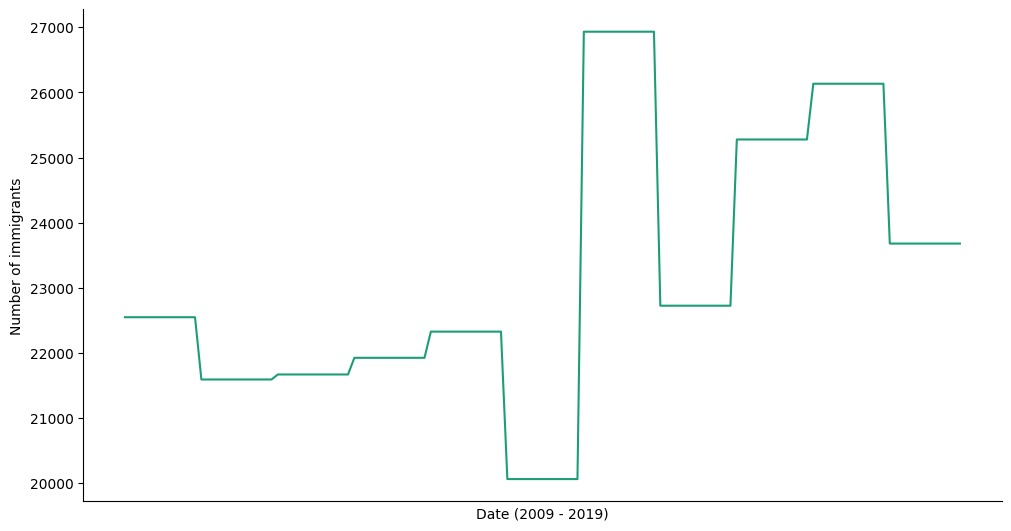

In [ ]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Number of immigrants']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = number_of_immigrants_df.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xticks([])
plt.xlabel('Date (2009 - 2019)')
_ = plt.ylabel('Number of immigrants')

#### Number of Population

In [ ]:
populations_df = pd.read_csv(f'{FILES_LOCATION}/populations.csv')
populations_df

<ipython-input-86-17743fa3224a>:1: DtypeWarning: Columns (12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  populations_df = pd.read_csv(f'{FILES_LOCATION}/populations.csv')


,REF_DATE,GEO,DGUID,Sex,Age group,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1971,Canada,2016A000011124,Both sexes,All ages,Persons,249,units,0,v466668,1.1.1,21962032.0,NaN,NaN,NaN,0
1,1971,Canada,2016A000011124,Both sexes,0 to 4 years,Persons,249,units,0,v466884,1.1.7,1836149.0,NaN,NaN,NaN,0
2,1971,Canada,2016A000011124,Both sexes,0 years,Persons,249,units,0,v466719,1.1.2,360077.0,NaN,NaN,NaN,0
3,1971,Canada,2016A000011124,Both sexes,1 year,Persons,249,units,0,v466752,1.1.3,364890.0,NaN,NaN,NaN,0
4,1971,Canada,2016A000011124,Both sexes,2 years,Persons,249,units,0,v466785,1.1.4,359388.0,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285091,2022,Nunavut,2016A000262,Females,45 to 64 years,Persons,249,units,0,v480269,15.3.103,3753.0,NaN,NaN,NaN,0
285092,2022,Nunavut,2016A000262,Females,65 years and over,Persons,249,units,0,v480272,15.3.104,762.0,NaN,NaN,NaN,0
285093,2022,Nunavut,2016A000262,Females,90 years and over,Persons,249,units,0,v480539,15.3.90,12.0,NaN,NaN,NaN,0
285094,2022,Nunavut,2016A000262,Females,Median age,Years,308,units,0,v480275,15.3.105,26.6,NaN,NaN,NaN,1


In [ ]:
# Keep only rows where GEO=Canada and Sex=Both sexes and Age group=All ages
populations_df = (populations_df[(populations_df['GEO'] == 'Canada') & (populations_df['Sex'] == 'Both sexes') & (populations_df['Age group'] == 'All ages')]
                  .reset_index()
                  .drop(columns='index')
                  )
populations_df

,REF_DATE,GEO,DGUID,Sex,Age group,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1971,Canada,2016A000011124,Both sexes,All ages,Persons,249,units,0,v466668,1.1.1,21962032.0,NaN,NaN,NaN,0
1,1972,Canada,2016A000011124,Both sexes,All ages,Persons,249,units,0,v466668,1.1.1,22218463.0,NaN,NaN,NaN,0
2,1973,Canada,2016A000011124,Both sexes,All ages,Persons,249,units,0,v466668,1.1.1,22491777.0,NaN,NaN,NaN,0
3,1974,Canada,2016A000011124,Both sexes,All ages,Persons,249,units,0,v466668,1.1.1,22807969.0,NaN,NaN,NaN,0
4,1975,Canada,2016A000011124,Both sexes,All ages,Persons,249,units,0,v466668,1.1.1,23143275.0,NaN,NaN,NaN,0
5,1976,Canada,2016A000011124,Both sexes,All ages,Persons,249,units,0,v466668,1.1.1,23449808.0,NaN,NaN,NaN,0
6,1977,Canada,2016A000011124,Both sexes,All ages,Persons,249,units,0,v466668,1.1.1,23725843.0,NaN,NaN,NaN,0
7,1978,Canada,2016A000011124,Both sexes,All ages,Persons,249,units,0,v466668,1.1.1,23963203.0,NaN,NaN,NaN,0
8,1979,Canada,2016A000011124,Both sexes,All ages,Persons,249,units,0,v466668,1.1.1,24201544.0,NaN,NaN,NaN,0
9,1980,Canada,2016A000011124,Both sexes,All ages,Persons,249,units,0,v466668,1.1.1,24515667.0,NaN,NaN,NaN,0


In [ ]:
# Check redundant columns
see_redundant(populations_df)

['REF_DATE']: [1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
['GEO']: ['Canada']
['DGUID']: ['2016A000011124']
['Sex']: ['Both sexes']
['Age group']: ['All ages']
['UOM']: ['Persons']
['UOM_ID']: [249]
['SCALAR_FACTOR']: ['units']
['SCALAR_ID']: [0]
['VECTOR']: ['v466668']
['COORDINATE']: ['1.1.1']
['VALUE']: [21962032.0, 22218463.0, 22491777.0, 22807969.0, 23143275.0, 23449808.0, 23725843.0, 23963203.0, 24201544.0, 24515667.0, 24819915.0, 25116942.0, 25366451.0, 25607053.0, 25842116.0, 26100278.0, 26446601.0, 26791747.0, 27276781.0, 27691138.0, 28037420.0, 28371264.0, 28684764.0, 29000663.0, 29302311.0, 29610218.0, 29905948.0, 30155173.0, 30401286.0, 30685730.0, 31020902.0, 31360079.0, 31644028.0, 31940655.0, 32243753.0, 32

In [ ]:
populations_df = populations_df.drop(columns=['GEO', 'DGUID', 'Sex', 'Age group', 'UOM', 'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE',
                                              'STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS'])
populations_df

,REF_DATE,VALUE
0,1971,21962032.0
1,1972,22218463.0
2,1973,22491777.0
3,1974,22807969.0
4,1975,23143275.0
5,1976,23449808.0
6,1977,23725843.0
7,1978,23963203.0
8,1979,24201544.0
9,1980,24515667.0


In [ ]:
# Remove unnecessary years. Keep from 2008 to allow for filling in synthetic data for months
populations_df = populations_df[(populations_df['REF_DATE'].astype(int) >= 2008) & (populations_df['REF_DATE'].astype(int) <= 2019)].reset_index().drop(columns='index')
populations_df

,REF_DATE,VALUE
0,2008,33247118.0
1,2009,33628895.0
2,2010,34004889.0
3,2011,34339328.0
4,2012,34714222.0
5,2013,35082954.0
6,2014,35437435.0
7,2015,35702908.0
8,2016,36109487.0
9,2017,36545236.0


In [ ]:
populations_df = populations_df.rename(columns= {'REF_DATE' : 'Date', "VALUE": "Population"})
populations_df

,Date,Population
0,2008,33247118.0
1,2009,33628895.0
2,2010,34004889.0
3,2011,34339328.0
4,2012,34714222.0
5,2013,35082954.0
6,2014,35437435.0
7,2015,35702908.0
8,2016,36109487.0
9,2017,36545236.0


In [ ]:
diff_list = diff_cal(populations_df['Population'])
diff_list
# diff_dict = {i: False for i in diff_list}
# diff_dict

[381777.0,
 375994.0,
 334439.0,
 374894.0,
 368732.0,
 354481.0,
 265473.0,
 406579.0,
 435749.0,
 519848.0,
 536146.0]

In [ ]:
populations_df['Population'] = populations_df['Population'].apply(value_adder, diff_list=diff_list)
populations_df

,Date,Population
0,2008,"[33247118.0, 33278932.75, 33310747.5, 33342562..."
1,2009,"[33628895.0, 33660227.83, 33691560.67, 3372289..."
2,2010,"[34004889.0, 34032758.92, 34060628.83, 3408849..."
3,2011,"[34339328.0, 34370569.17, 34401810.33, 3443305..."
4,2012,"[34714222.0, 34744949.67, 34775677.33, 3480640..."
5,2013,"[35082954.0, 35112494.08, 35142034.17, 3517157..."
6,2014,"[35437435.0, 35459557.75, 35481680.5, 35503803..."
7,2015,"[35702908.0, 35736789.58, 35770671.17, 3580455..."
8,2016,"[36109487.0, 36145799.42, 36182111.83, 3621842..."
9,2017,"[36545236.0, 36588556.67, 36631877.33, 3667519..."


In [ ]:
populations_df = populations_df.drop(index=11)
populations_df

,Date,Population
0,2008,"[33247118.0, 33278932.75, 33310747.5, 33342562..."
1,2009,"[33628895.0, 33660227.83, 33691560.67, 3372289..."
2,2010,"[34004889.0, 34032758.92, 34060628.83, 3408849..."
3,2011,"[34339328.0, 34370569.17, 34401810.33, 3443305..."
4,2012,"[34714222.0, 34744949.67, 34775677.33, 3480640..."
5,2013,"[35082954.0, 35112494.08, 35142034.17, 3517157..."
6,2014,"[35437435.0, 35459557.75, 35481680.5, 35503803..."
7,2015,"[35702908.0, 35736789.58, 35770671.17, 3580455..."
8,2016,"[36109487.0, 36145799.42, 36182111.83, 3621842..."
9,2017,"[36545236.0, 36588556.67, 36631877.33, 3667519..."


In [ ]:
populations_df['Date'] = populations_df['Date'].apply(month_adder, add_1=True)
populations_df

,Date,Population
0,"[2009-01, 2009-02, 2009-03, 2009-04, 2009-05, ...","[33247118.0, 33278932.75, 33310747.5, 33342562..."
1,"[2010-01, 2010-02, 2010-03, 2010-04, 2010-05, ...","[33628895.0, 33660227.83, 33691560.67, 3372289..."
2,"[2011-01, 2011-02, 2011-03, 2011-04, 2011-05, ...","[34004889.0, 34032758.92, 34060628.83, 3408849..."
3,"[2012-01, 2012-02, 2012-03, 2012-04, 2012-05, ...","[34339328.0, 34370569.17, 34401810.33, 3443305..."
4,"[2013-01, 2013-02, 2013-03, 2013-04, 2013-05, ...","[34714222.0, 34744949.67, 34775677.33, 3480640..."
5,"[2014-01, 2014-02, 2014-03, 2014-04, 2014-05, ...","[35082954.0, 35112494.08, 35142034.17, 3517157..."
6,"[2015-01, 2015-02, 2015-03, 2015-04, 2015-05, ...","[35437435.0, 35459557.75, 35481680.5, 35503803..."
7,"[2016-01, 2016-02, 2016-03, 2016-04, 2016-05, ...","[35702908.0, 35736789.58, 35770671.17, 3580455..."
8,"[2017-01, 2017-02, 2017-03, 2017-04, 2017-05, ...","[36109487.0, 36145799.42, 36182111.83, 3621842..."
9,"[2018-01, 2018-02, 2018-03, 2018-04, 2018-05, ...","[36545236.0, 36588556.67, 36631877.33, 3667519..."


In [ ]:
populations_df = populations_df.explode(['Date', 'Population']).reset_index().drop(columns='index')
populations_df

,Date,Population
0,2009-01,33247118.0
1,2009-02,33278932.75
2,2009-03,33310747.5
3,2009-04,33342562.25
4,2009-05,33374377.0
...,...,...
127,2019-08,37377835.83
128,2019-09,37422514.67
129,2019-10,37467193.5
130,2019-11,37511872.33


In [ ]:
populations_df['Population'] = populations_df['Population'].astype(int)
populations_df

,Date,Population
0,2009-01,33247118
1,2009-02,33278932
2,2009-03,33310747
3,2009-04,33342562
4,2009-05,33374377
...,...,...
127,2019-08,37377835
128,2019-09,37422514
129,2019-10,37467193
130,2019-11,37511872


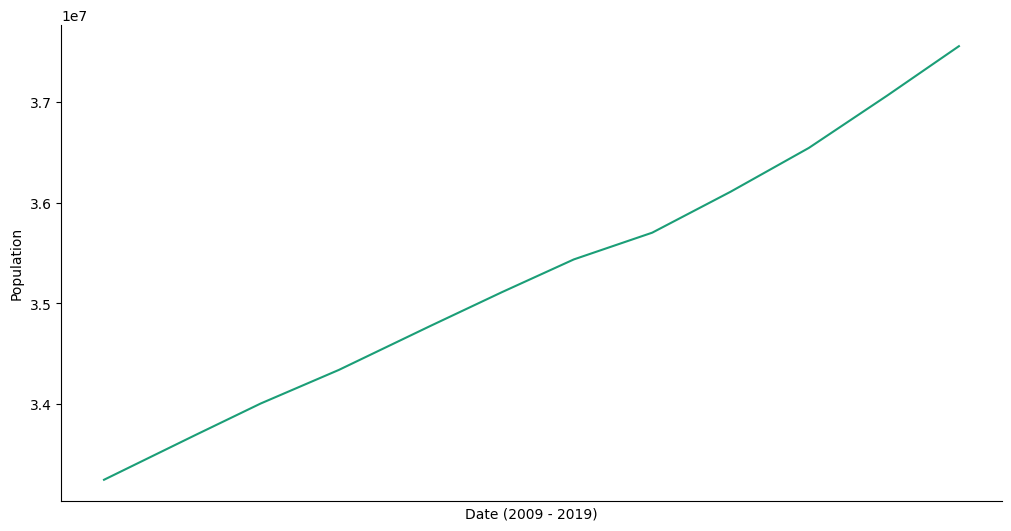

In [ ]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))

  xs = series['Date']
  ys = series['Population']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = populations_df.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xticks([])
plt.xlabel('Date (2009 - 2019)')
_ = plt.ylabel('Population')

#### Merging Data

In [ ]:
df_list = [econ_indicators,
CPI_df,
GDP_df,
average_housing_df,
interest_rate_df,
new_housing_df,
number_of_families_df,
number_of_immigrants_df,
populations_df]

In [ ]:
econ_indicators['Date'] = econ_indicators['Date'].astype(str)
CPI_df['Date'] = CPI_df['Date'].astype(str)
GDP_df['Date'] = GDP_df['Date'].astype(str)
average_housing_df['Date'] = average_housing_df['Date'].astype(str)
interest_rate_df['Date'] = interest_rate_df['Date'].astype(str)
new_housing_df['Date'] = new_housing_df['Date'].astype(str)
number_of_families_df['Date'] = number_of_families_df['Date'].astype(str)
number_of_immigrants_df['Date'] = number_of_immigrants_df['Date'].astype(str)
populations_df['Date'] = populations_df['Date'].astype(str)

<ipython-input-100-8f9c27ad70b9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GDP_df['Date'] = GDP_df['Date'].astype(str)
<ipython-input-100-8f9c27ad70b9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  average_housing_df['Date'] = average_housing_df['Date'].astype(str)


In [ ]:
merged_df = reduce(lambda left, right: pd.merge(left,right,on=['Date'], how='outer'), df_list)
merged_df

,Date,Real GDP Growth,Unemp. Rate,Emp. Growth,CPI Inflation,Core Inflation (CPIX),GDP Inflation,10 Year Bnchmk. Govt. Bond Rate,Exchange Rate (U.S.$),US Real GDP Growth,...,Average price,One storey price,Two storey price,Townhouse price,Apartment price,interest rate,Housing index,Number of families,Number of immigrants,Population
0,2009-01,-2.5,8.3,-1.6,0.3,1.7,-2.1,3.3,87.9,-2.5,...,275712.91,266900,365800,265200,225700,1.55,87.0,9280000,22548,33247118
1,2009-02,-2.5,8.3,-1.6,0.3,1.7,-2.1,3.3,87.9,-2.5,...,284924.45,264300,362100,263100,224400,1.25,86.4,9288333,22548,33278932
2,2009-03,-2.5,8.3,-1.6,0.3,1.7,-2.1,3.3,87.9,-2.5,...,290405.99,261200,360500,260900,223700,0.77,86.0,9296666,22548,33310747
3,2009-04,-2.5,8.3,-1.6,0.3,1.7,-2.1,3.3,87.9,-2.5,...,307191.39,262700,362100,260300,224800,0.66,85.5,9305000,22548,33342562
4,2009-05,-2.5,8.3,-1.6,0.3,1.7,-2.1,3.3,87.9,-2.5,...,320489.45,264100,365800,261100,226500,0.50,85.4,9313333,22548,33374377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,2019-08,1.5,5.7,2.0,2.0,1.9,2,1.5,75.4,2.3,...,494477.32,435100,666500,479900,415700,2.00,103.0,10230000,23679,37377835
128,2019-09,1.5,5.7,2.0,2.0,1.9,2,1.5,75.4,2.3,...,513180.82,437700,670300,483400,419500,2.00,103.2,10240000,23679,37422514
129,2019-10,1.5,5.7,2.0,2.0,1.9,2,1.5,75.4,2.3,...,525979.64,440300,674600,486800,421700,2.00,103.3,10250000,23679,37467193
130,2019-11,1.5,5.7,2.0,2.0,1.9,2,1.5,75.4,2.3,...,529926.62,442000,676600,489700,425900,2.00,103.2,10260000,23679,37511872


In [ ]:
merged_df.columns

Index(['Date', 'Real GDP Growth', 'Unemp. Rate', 'Emp. Growth',
       'CPI Inflation', 'Core Inflation (CPIX)', 'GDP Inflation',
       '10 Year  Bnchmk. Govt. Bond Rate', 'Exchange Rate         (U.S.$)',
       'US Real GDP Growth', 'US Gov't Bond Rate (10 years)',
       'US CPI Inflation', 'US GDP Inflation', 'Oil Price   WTI   $US/Barrel',
       'Gas Price  Henry Hub   $US/mmbtu', 'ATOM_V41693242', 'CPIW',
       'CPI_COMMON', 'CPI_MEDIAN', 'CPI_TRIM', 'STATIC_CPIXFET',
       'STATIC_TOTALCPICHANGE', 'GDP (millions 2012 Constant Price)',
       'Average price', 'One storey price', 'Two storey price',
       'Townhouse price', 'Apartment price', 'interest rate', 'Housing index',
       'Number of families', 'Number of immigrants', 'Population'],
      dtype='object')

In [ ]:
merged_df.dtypes

Date                                   object
Real GDP Growth                       float64
Unemp. Rate                           float64
Emp. Growth                           float64
CPI Inflation                         float64
Core Inflation (CPIX)                 float64
GDP Inflation                          object
10 Year  Bnchmk. Govt. Bond Rate      float64
Exchange Rate         (U.S.$)         float64
US Real GDP Growth                    float64
US Gov't Bond Rate (10 years)         float64
US CPI Inflation                      float64
US GDP Inflation                      float64
Oil Price   WTI   $US/Barrel           object
Gas Price  Henry Hub   $US/mmbtu      float64
ATOM_V41693242                        float64
CPIW                                  float64
CPI_COMMON                            float64
CPI_MEDIAN                            float64
CPI_TRIM                              float64
STATIC_CPIXFET                        float64
STATIC_TOTALCPICHANGE             

#### Cleaning

In [ ]:
# import missingno as msno

In [ ]:
# msno.matrix(merged_df)

In [ ]:
# for col in merged_df.columns:
#   display(merged_df[merged_df[col].isna()])

In [ ]:
def date_numeric(val):
  d = dt.strptime(val, '%Y-%m').toordinal()
  return d

merged_df['Date'] = merged_df['Date'].apply(date_numeric)
merged_df

,Date,Real GDP Growth,Unemp. Rate,Emp. Growth,CPI Inflation,Core Inflation (CPIX),GDP Inflation,10 Year Bnchmk. Govt. Bond Rate,Exchange Rate (U.S.$),US Real GDP Growth,...,Average price,One storey price,Two storey price,Townhouse price,Apartment price,interest rate,Housing index,Number of families,Number of immigrants,Population
0,733408,-2.5,8.3,-1.6,0.3,1.7,-2.1,3.3,87.9,-2.5,...,275712.91,266900,365800,265200,225700,1.55,87.0,9280000,22548,33247118
1,733439,-2.5,8.3,-1.6,0.3,1.7,-2.1,3.3,87.9,-2.5,...,284924.45,264300,362100,263100,224400,1.25,86.4,9288333,22548,33278932
2,733467,-2.5,8.3,-1.6,0.3,1.7,-2.1,3.3,87.9,-2.5,...,290405.99,261200,360500,260900,223700,0.77,86.0,9296666,22548,33310747
3,733498,-2.5,8.3,-1.6,0.3,1.7,-2.1,3.3,87.9,-2.5,...,307191.39,262700,362100,260300,224800,0.66,85.5,9305000,22548,33342562
4,733528,-2.5,8.3,-1.6,0.3,1.7,-2.1,3.3,87.9,-2.5,...,320489.45,264100,365800,261100,226500,0.50,85.4,9313333,22548,33374377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,737272,1.5,5.7,2.0,2.0,1.9,2,1.5,75.4,2.3,...,494477.32,435100,666500,479900,415700,2.00,103.0,10230000,23679,37377835
128,737303,1.5,5.7,2.0,2.0,1.9,2,1.5,75.4,2.3,...,513180.82,437700,670300,483400,419500,2.00,103.2,10240000,23679,37422514
129,737333,1.5,5.7,2.0,2.0,1.9,2,1.5,75.4,2.3,...,525979.64,440300,674600,486800,421700,2.00,103.3,10250000,23679,37467193
130,737364,1.5,5.7,2.0,2.0,1.9,2,1.5,75.4,2.3,...,529926.62,442000,676600,489700,425900,2.00,103.2,10260000,23679,37511872


In [ ]:
# merged_df.dtypes

In [ ]:
merged_df = merged_df.astype({'GDP Inflation': float, 'Oil Price   WTI   $US/Barrel': float, 'Number of immigrants': int})
merged_df

,Date,Real GDP Growth,Unemp. Rate,Emp. Growth,CPI Inflation,Core Inflation (CPIX),GDP Inflation,10 Year Bnchmk. Govt. Bond Rate,Exchange Rate (U.S.$),US Real GDP Growth,...,Average price,One storey price,Two storey price,Townhouse price,Apartment price,interest rate,Housing index,Number of families,Number of immigrants,Population
0,733408,-2.5,8.3,-1.6,0.3,1.7,-2.1,3.3,87.9,-2.5,...,275712.91,266900,365800,265200,225700,1.55,87.0,9280000,22548,33247118
1,733439,-2.5,8.3,-1.6,0.3,1.7,-2.1,3.3,87.9,-2.5,...,284924.45,264300,362100,263100,224400,1.25,86.4,9288333,22548,33278932
2,733467,-2.5,8.3,-1.6,0.3,1.7,-2.1,3.3,87.9,-2.5,...,290405.99,261200,360500,260900,223700,0.77,86.0,9296666,22548,33310747
3,733498,-2.5,8.3,-1.6,0.3,1.7,-2.1,3.3,87.9,-2.5,...,307191.39,262700,362100,260300,224800,0.66,85.5,9305000,22548,33342562
4,733528,-2.5,8.3,-1.6,0.3,1.7,-2.1,3.3,87.9,-2.5,...,320489.45,264100,365800,261100,226500,0.50,85.4,9313333,22548,33374377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,737272,1.5,5.7,2.0,2.0,1.9,2.0,1.5,75.4,2.3,...,494477.32,435100,666500,479900,415700,2.00,103.0,10230000,23679,37377835
128,737303,1.5,5.7,2.0,2.0,1.9,2.0,1.5,75.4,2.3,...,513180.82,437700,670300,483400,419500,2.00,103.2,10240000,23679,37422514
129,737333,1.5,5.7,2.0,2.0,1.9,2.0,1.5,75.4,2.3,...,525979.64,440300,674600,486800,421700,2.00,103.3,10250000,23679,37467193
130,737364,1.5,5.7,2.0,2.0,1.9,2.0,1.5,75.4,2.3,...,529926.62,442000,676600,489700,425900,2.00,103.2,10260000,23679,37511872


In [ ]:
# merged_df.dtypes

In [ ]:
# str(dt.fromordinal(733408))[:7]

#### Model

In [ ]:
X = merged_df.drop(columns='Average price')
y = merged_df['Average price']

In [ ]:
# X = merged_df['Date']
# y = merged_df.drop(columns='Date')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8)

In [ ]:
param_grid = {'alpha' : [12, 15, 20, 25, 30]}

In [ ]:
ridge_model = Ridge(alpha=1)
grid_search = GridSearchCV(ridge_model, param_grid)
grid_search.fit(X_train, y_train)
best_param = grid_search.best_params_
best_param

{'alpha': 30}

In [ ]:
best_ridge_model = grid_search.best_estimator_
best_ridge_model.fit(X_train, y_train)

Ridge(alpha=30)

In [ ]:
ridge_predict = best_ridge_model.predict(X_val)
rmse = mean_squared_error(y_val, ridge_predict, squared=False)
rmse

13207.3327810814

In [ ]:
# ridge_cv_results = cross_validate(ridge_model, X_val, y_val, cv=3)
# ridge_cv_results

In [ ]:
ridge_predict = best_ridge_model.predict(X_test)
rmse = mean_squared_error(y_test, ridge_predict, squared=False)
rmse

17947.18193226536

In [ ]:
avg_of_Average_price = round(merged_df['Average price'].mean(), 2)
avg_of_Average_price

417068.92